# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- <b>Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.</b><br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

`utils.py` is a file where there are some methods used in this and the other notebooks generated for the project.

In [1]:
import json
import pandas as pd
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
players_df = pd.DataFrame(players)

events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}

### Some data preparation

With the function `prepare_players`, only the columns `playerId` and `role` of the `players_df` DataFrame are kept, in order to use this information to make further analysis, based on the role of each player. Look at the `utils.py` file for further information.

In [4]:
players_df = prepare_players(players_df)

Before starting the analysis, there is a kind of **trajectory filtering** to do. In fact, all the events with _Goal Kick_ and _Save attempt_ are removed from all the DataFrames, since they all have a dummy value as a starting position, which can be either {'y': 0, 'x': 0} or {'y': 100, 'x': 100} and they would influence and modify the real distance traveled by goalkeepers. (Reference: https://dataglossary.wyscout.com/goal_kick/).

In [5]:
events_to_check = pd.DataFrame()
for nation in events_df:
    goal_kick_events = events_df[nation][(events_df[nation]['subEventName'] == 'Goal kick')]
    save_attempt_events = events_df[nation][(events_df[nation]['eventName'] == 'Save attempt')]
    events_to_check = pd.concat([events_to_check, goal_kick_events, save_attempt_events])

In [6]:
for row in events_to_check.iterrows():
    if not (row[1]['positions'][0] == {'y': 0, 'x': 0} or row[1]['positions'][0] == {'y': 100, 'x': 100}):
        print(True)

As expected, all the events with _Goal kick_ as `subEventName` and all the events with _Save attempt_ as `eventName` have as starting position dummy values, so for the analysis purpose they are noise and for this reason removed from all the DataFrames.

In [7]:
for nation in events_df:
    events_df[nation] = events_df[nation][(events_df[nation]['subEventName'] != 'Goal kick')]
    events_df[nation] = events_df[nation][(events_df[nation]['eventName'] != 'Save attempt')]

In order to analyze and get hint and interesting information about each competition, they all are first analyzed separately. In the end of the notebook is present the total distance distribution.

In [8]:
total_tmp_df = pd.DataFrame()
total_player_role_df = pd.DataFrame()
lineup_players_df = pd.DataFrame()
substitution_players_df = pd.DataFrame()

The following function is used for analyzing the championship not considering the difference between the lineup and substituted players.

In [9]:
def general_analysis(competition_area, competition_name):
    print('General analysis for %s' %competition_name)

    #retrieve the events for the competition
    competition_events_df = prepare_events(extract_events(events_df, competition_area))
    events_players_df = pd.merge(competition_events_df, players_df, on='playerId', how='left')

    #plot the number of events generated by role
    events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    #compute the distance between two consecutive points with the same player and match id
    events_players_distances_df = compute_distance(events_players_df)

    #sums the distances for each player and match    
    competition_tmp_df = sum_distances(events_players_distances_df)

    distances_count = count_distances(competition_tmp_df)

    #plot the histogram of the distances
    plot_histogram(distances_count, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of the distances computed with the %s events' %competition_name)


    competition_players_role_distances_df = pd.merge(competition_tmp_df, players_df, on='playerId', how='left')
    players_role_distances_df = group_by_distance_role(competition_players_role_distances_df)

    #plot the histogram of the distances by role
    plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the %s events' %competition_name)

    return competition_events_df, competition_tmp_df, competition_players_role_distances_df

The following function is used to analyze the data related to the lineup players.

In [10]:
def lineup_analysis(events_df, competition_area, competition_name):
    print('Lineup analysis for %s' %competition_name)
    
    # loading the matches data
    with open('./data/matches/matches_%s.json' %competition_area) as json_data:
        competition_matches = pd.DataFrame(json.load(json_data))

    # retrieves the substitutions for each match
    substitutions = {}
    for match in competition_matches.iterrows():
        for key in list(match[1]['teamsData']):
            for sub in match[1]['teamsData'][key]['formation']['substitutions']:
                if(type(sub) == dict):
                    if match[1]['wyId'] in substitutions:
                        substitutions[match[1]['wyId']].append(sub['playerIn'])
                    else:
                        substitutions[match[1]['wyId']] = [sub['playerIn']]

    # this DataFrame all the events generated by the players that have been substituted
    filtered_df = pd.DataFrame()

    for match, player_ids in substitutions.items():
        filtered_df = pd.concat([filtered_df, events_df[(events_df['matchId'] == match) & (events_df['playerId'].isin(player_ids))]])

    # this DataFrame contains all the events generated by the players that are in the lineup
    events_no_subs_df = events_df.drop(list(filtered_df.index))
    events_no_subs_df = pd.merge(events_no_subs_df, players_df, on='playerId', how='left')

    #this is pretty the same as the general analysis but we are considering only the players that are in the lineup
    events_no_subs_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    events_players_distances_no_sub_df = compute_distance(events_no_subs_df)
    
    competition_tmp_no_sub_df = sum_distances(events_players_distances_no_sub_df)

    distances_count_no_sub = count_distances(competition_tmp_no_sub_df)

    plot_histogram(distances_count_no_sub, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances (with only lineup players) computed with the %s events' %competition_name)

    competition_players_role_distances_no_sub_df = pd.merge(competition_tmp_no_sub_df, players_df, on='playerId', how='left')

    players_role_distances_no_sub_df = group_by_distance_role(competition_players_role_distances_no_sub_df)

    plot_histogram_per_role(players_role_distances_no_sub_df, 'Histogram of count of distances by role (with only lineup players) computed with the %s events' %competition_name)

    return filtered_df, competition_players_role_distances_no_sub_df


In [11]:
def substitution_analysis(events_df, competition_area, competition_name):
    print('Substitution analysis for %s' %competition_name)
    #filtered_df is the DataFrame containing only the events generated by the players that have been substituted
    events_subs_df = pd.merge(events_df, players_df, on='playerId', how='left')

    #this is pretty the same as the general analysis but we are considering only the players that have been substituted
    events_subs_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    events_players_distances_sub_df = compute_distance(events_subs_df)
    tmp_sub_df = sum_distances(events_players_distances_sub_df)
    distances_count_sub = count_distances(tmp_sub_df)

    plot_histogram(distances_count_sub, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances (with only substituted players) computed with the %s events' %competition_name)

    players_role_distances_sub_df = pd.merge(tmp_sub_df, players_df, on='playerId', how='left')
    players_role_distances_sub_df = group_by_distance_role(players_role_distances_sub_df)

    plot_histogram_per_role(players_role_distances_sub_df, 'Histogram of count of distances by role (with only substituted players) computed with the %s events' %competition_name)

    return players_role_distances_sub_df

In [12]:
def total_analysis():
    print('General analysis')
    
    players_role_distances_df = group_by_distance_role(total_player_role_df)
    
    distances_count = count_distances(total_tmp_df)

    plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events")

    plot_histogram_per_role(players_role_distances_df, "Histogram of count of distances by role computed with tall the competitions' events")
    

In [13]:
def lineup_total_analysis():
    print('Lineup analysis')

    players_role_distances_df = group_by_distance_role(lineup_players_df)
    
    distances_count = count_distances(lineup_players_df)

    plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events (with only lineup players)")

    plot_histogram_per_role(players_role_distances_df, "Histogram of count of distances by role computed with all the competitions' events (with only lineup players)")

In [14]:
def substitution_total_analysis():
    print('Substitution analysis')

    distance_counts = substitution_players_df.groupby('distance')['count'].sum().reset_index()

    distance_counts['distance'] = distance_counts['distance'].astype(int)
    
    plot_histogram(distance_counts, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events (with only substituted players)")

    distance_role = substitution_players_df.sort_values(by=['distance']).groupby(by=['distance', 'role'])['count'].sum().reset_index()
    plot_histogram_per_role(distance_role, "Histogram of count of distances by role computed with all the competitions' events (with only substituted players)")

It is known that each competition has some peculiarities and these are present in the following plots. However, there are also some common points that all competitions share, such as:
-   the number of events generated by the midfielders and defenders compared to goalkeepers and attackers: in fact, the first roles often generate more events than the second ones;
-   the highest number of substitutions that happen during a match is among the midfielders and attackers: this brings the defenders to be the ones who often own the highest number of events they are involved into;
-   there may be a difference of traveled distance among the sub-roles there are in each football role, i.e. center-backs and wing-backs for the defenders, strikers and wingers for the attackers. The analysis could not go further into this because of the absence of the specific tag for each sub-role and also because football is a dynamic sport and so there may be players who can also cover a role they do not belong to make up for the shortage of players in that pitch zone or for other reasons.

An important point to stress on is the fact that the distances present in the next plots cannot be compared with the real distances covered by players in matches. In fact, in real matches players travel for 10 kilometers, on average, while in the results we have that the longest distance traveled by a player is around 4400 meters (covered by a midfielder in the Italian first division). This discrepancy is due to the fact that this analysis is based on the events that are generated during a match, such as a duel, pass, foul and so on, and there are not events that register movements of players without causing any events.

The analysis starts considering the general distribution of the traveled distance by all players, first not making any difference among the different roles and then with. What can be noticed is that in both plots are present two gaussian distributions, the first one with the mean around 200-400 meters and the second one around 1400-1700 meters. Focusing only on the plot where the traveled distance is split by roles, however, one can notice that the curves of the defenders and goalkeepers are exactly a gaussian, so the analysis goes further to understand why the midfielders and attackers also present the first bell curve.<br>
In order to understand the presence of the double gaussian for the two roles just mentioned, a further analysis about the lineup and subs is made:
-   When considering the plots about the lineup players, we can exactly notice there are gaussian curves. This means that the behavior noticed in the general analysis is caused by the traveled distance of the subs;
-   The subs' traveled distance plot, nevertheless, has a shape comparable to a power law. In fact, usually substitutions happen at the end of the match and this causes a small distance covered by players.

These two results can be directly compared with the shapes and distributions of the human mobility. In fact, considering the results of the work of Brockmann et al. [Brockmann, D., Hufnagel, L. & Geisel, T. The scaling laws of human travel. Nature 439, 462–465 (2006). https://doi.org/10.1038/nature04292], we can see that if we analyze the traveled distance by the subs (which usually play for a shorter period of time than the lineup players), the results show a power law distribution, exactly the one that also show the covered distance of bills after 1-4 days.

If we instead analyze the distance covered by players who play for a longer time, i.e. the lineup players, the distribution changes, showing a normal distribution, a behavior that can be seen also in the mentioned work when analyzing the distribution of the bills with an initial entry on Omaha. In fact, if in the work this behavior is probably due to the fact that long periods of rest might be an intrinsic temporal property of dispersal, in a football match that can be interpreted as the fact that the two teams do not always go from a pitch area to another one, but there is usually a period where a team attacks and another one defends, so there is a so defined "period of rest".

## Italian first division

Serie A is often associated with strong defensive play and tactical discipline, with teams prioritizing defensive solidity.<br>
This can be noticed from the following plots, noticing that the highest number of the events generated in the Italian first division is made by defenders. Furthermore, analyzing the role distribution of the traveled distance by the defenders, it is also noticeable the fact that they cover a distance similar to the midfielders, probably because they also help in the offensive movements.

General analysis for Italian first division


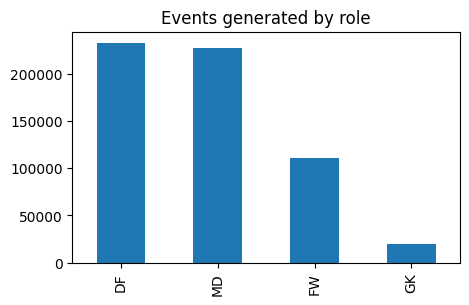

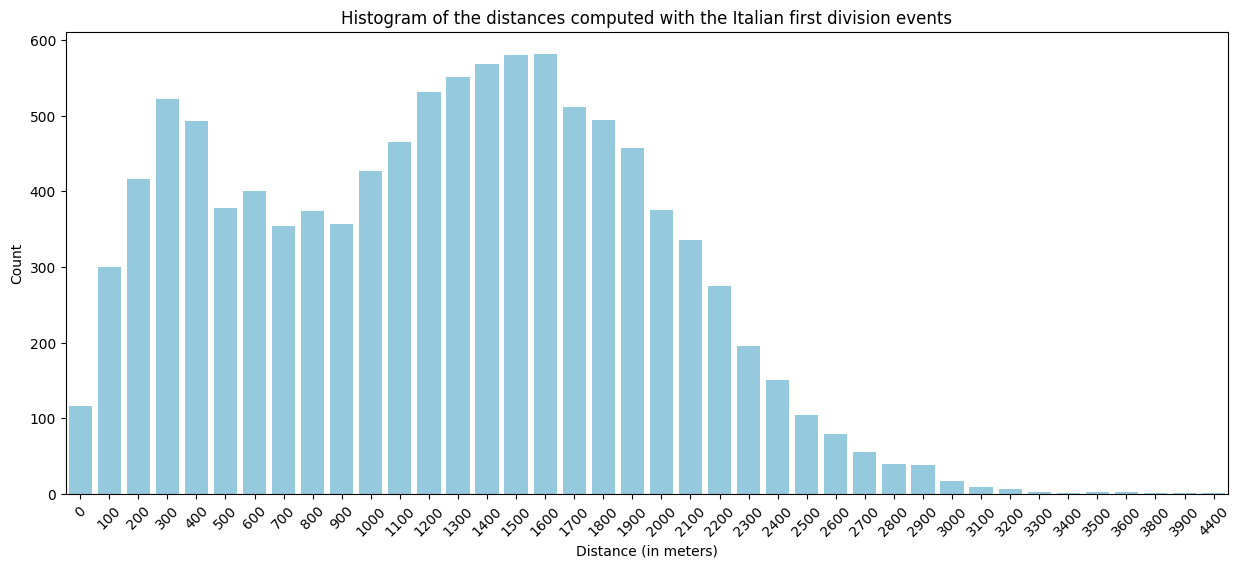

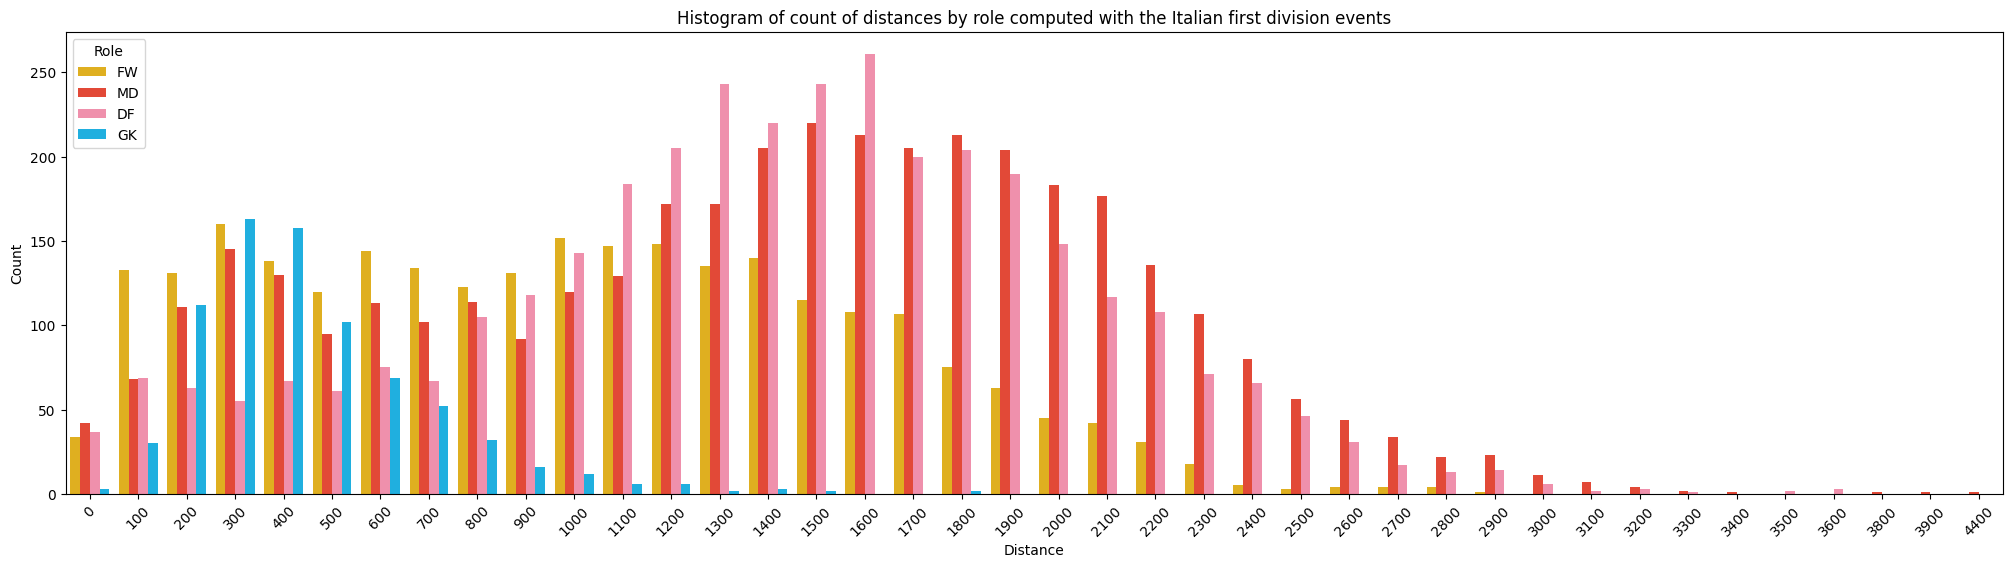

In [15]:
italian_events_df, df1, df2 = general_analysis('Italy', 'Italian first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for Italian first division


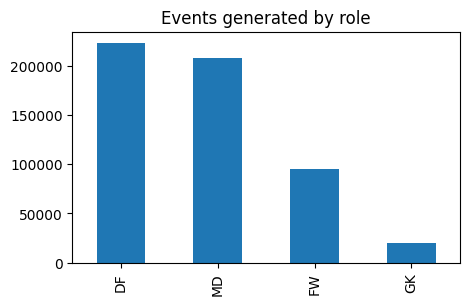

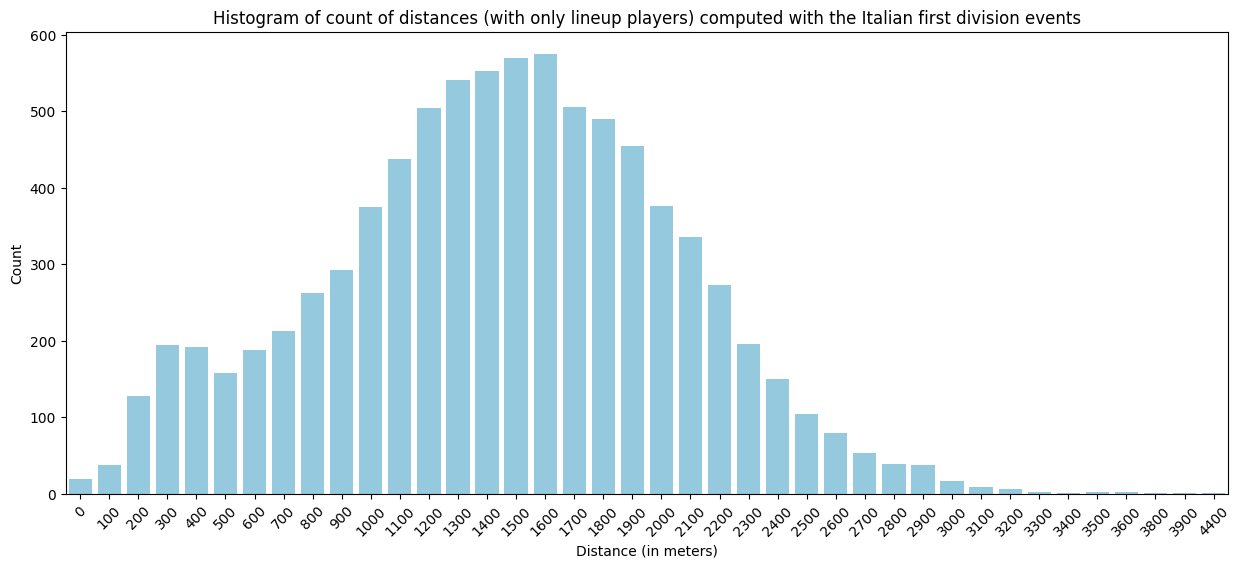

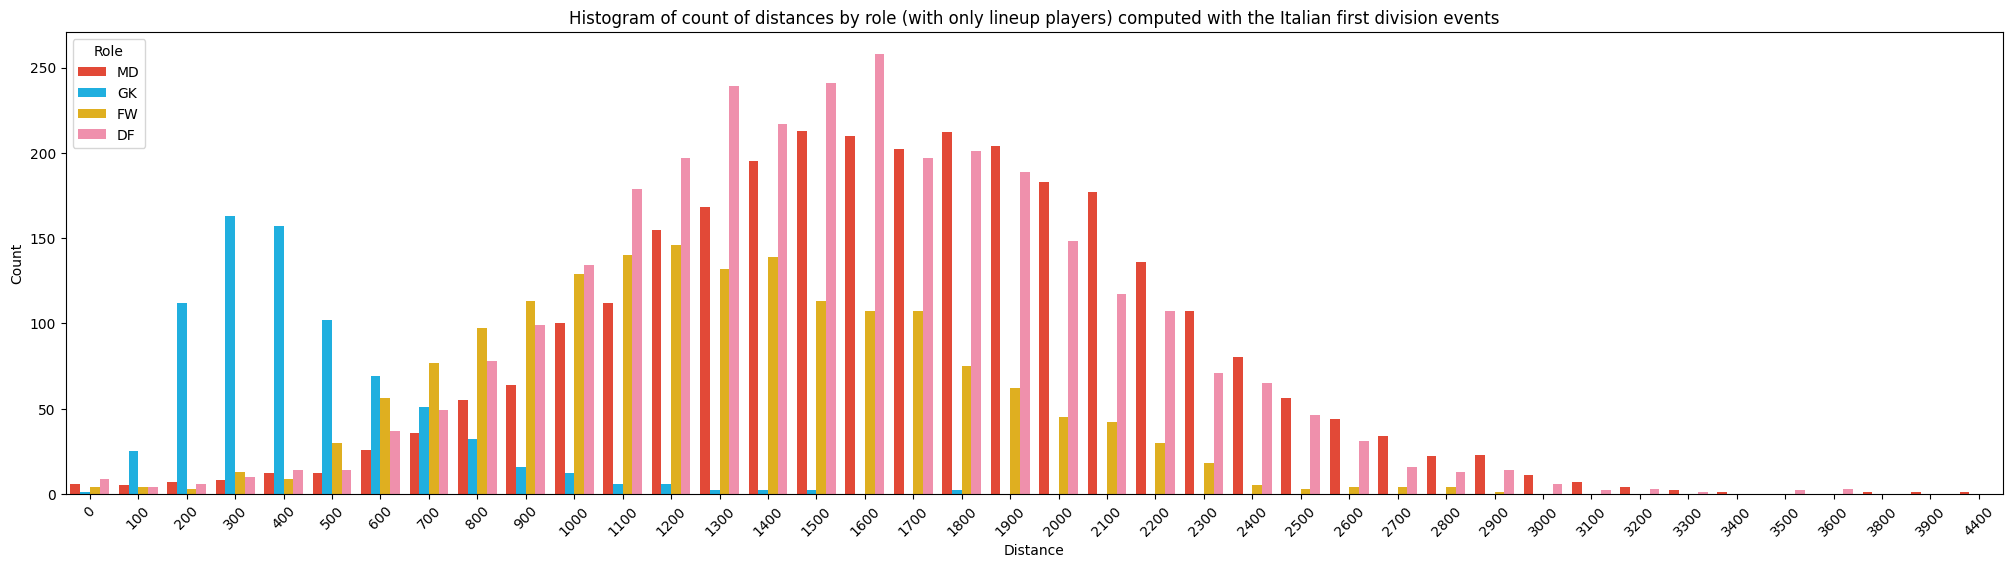

In [16]:
filtered_df, df1 = lineup_analysis(italian_events_df, 'Italy', 'Italian first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for Italian first division


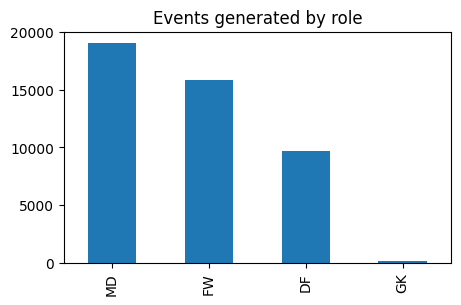

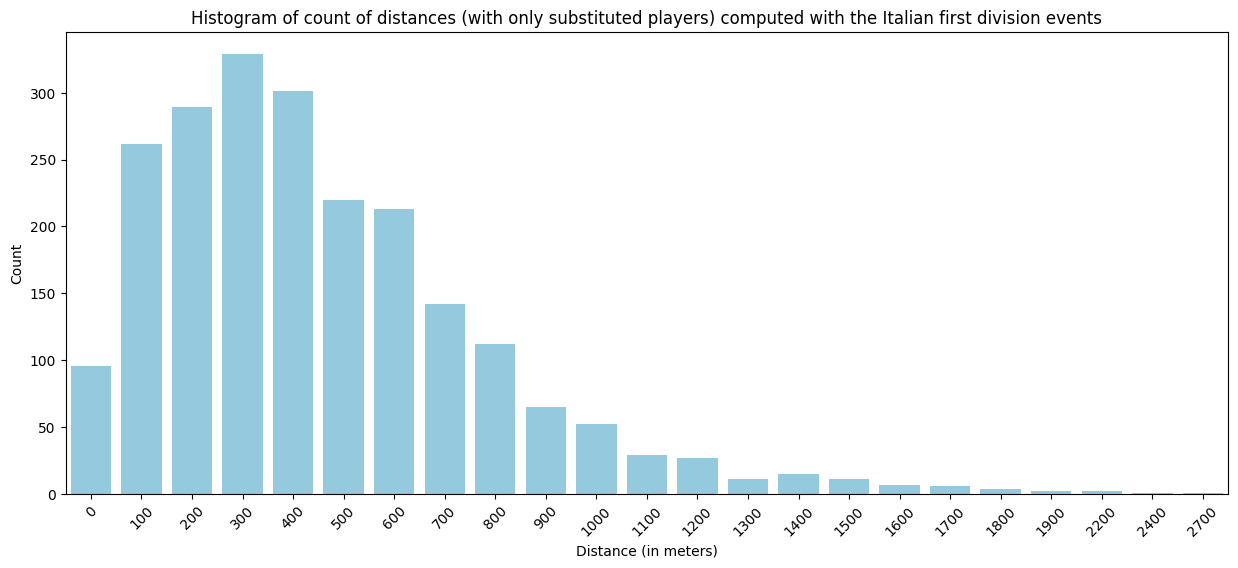

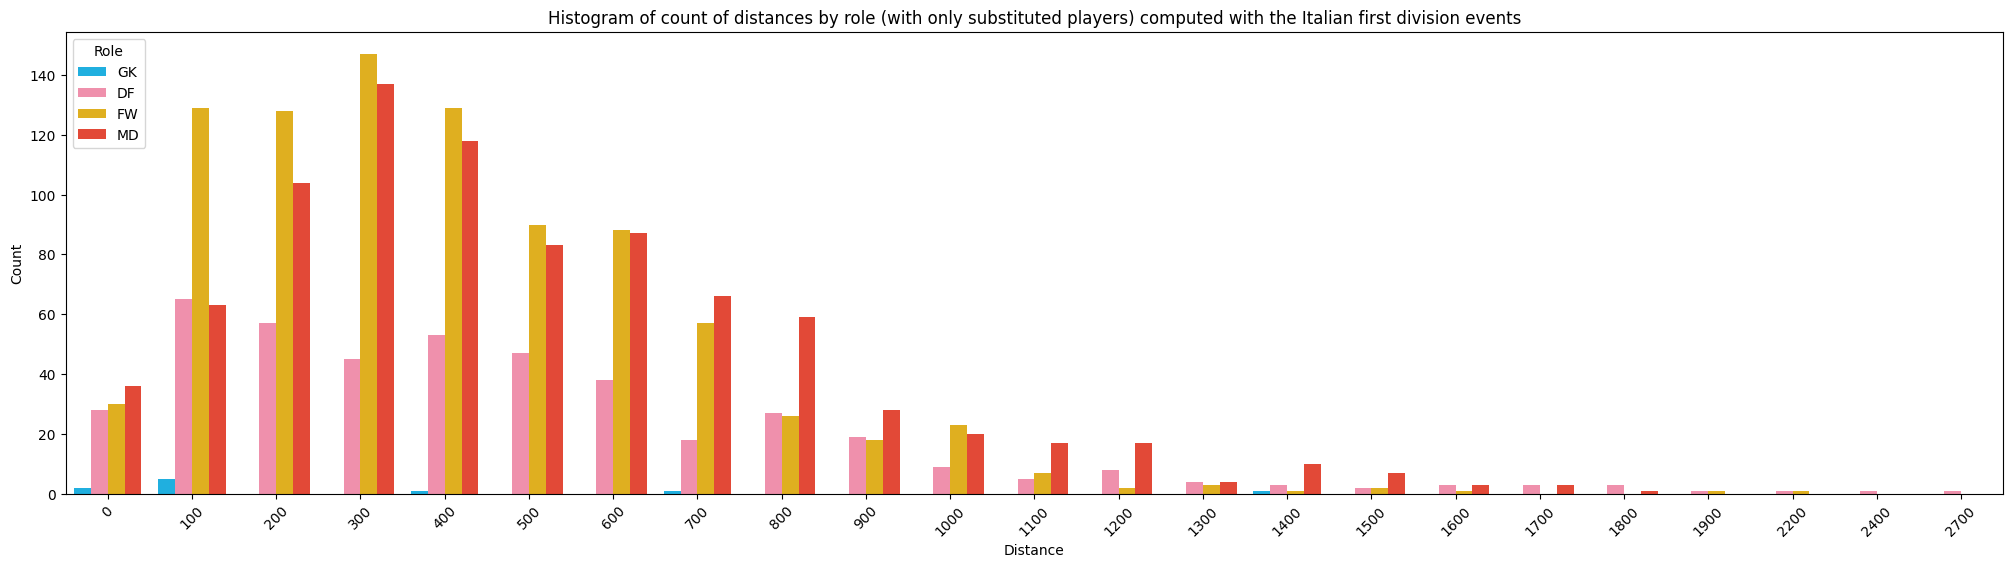

In [17]:
df1 = substitution_analysis(filtered_df, 'Italy', 'Italian first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## English first division analysis

General analysis for English first division


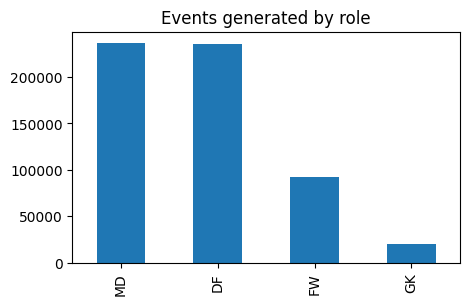

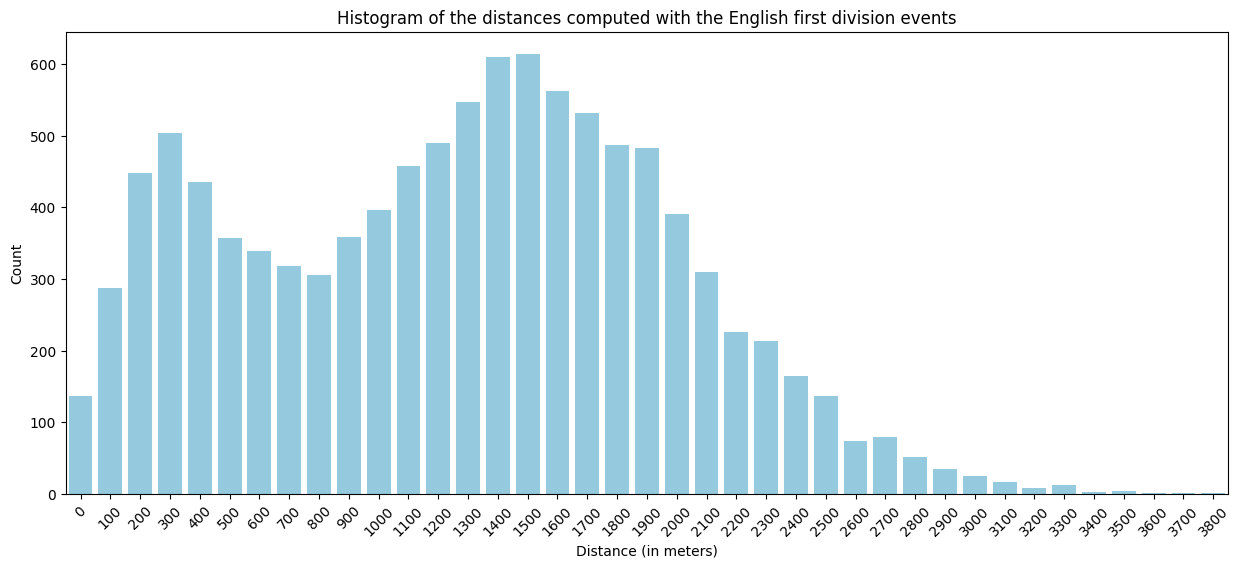

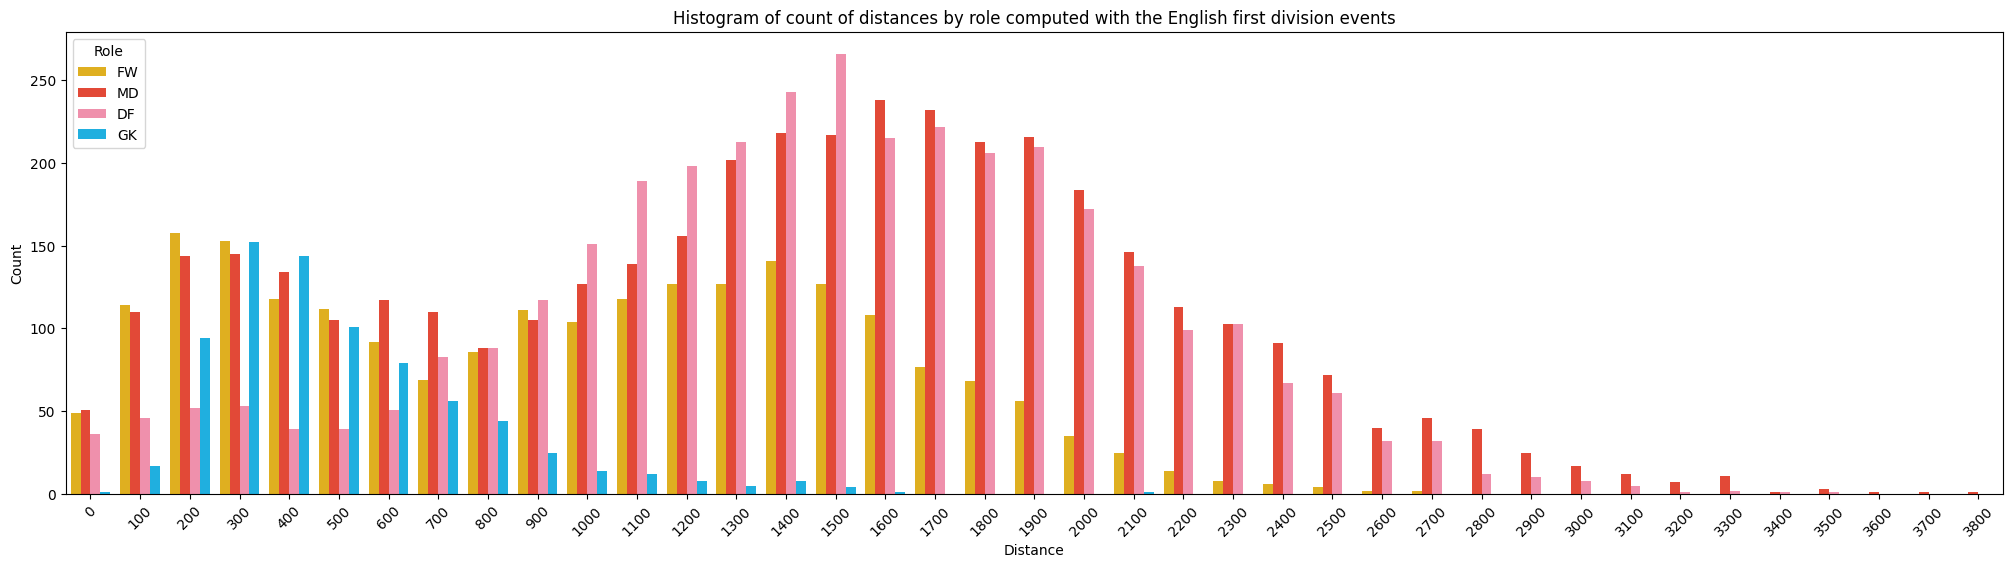

In [18]:
english_events_df, df1, df2 = general_analysis('England', 'English first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for English first division


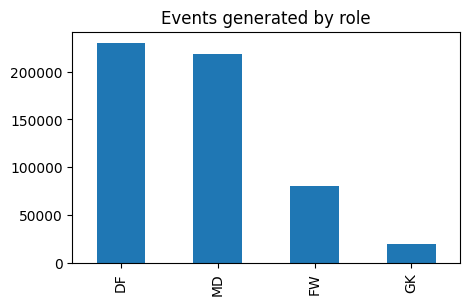

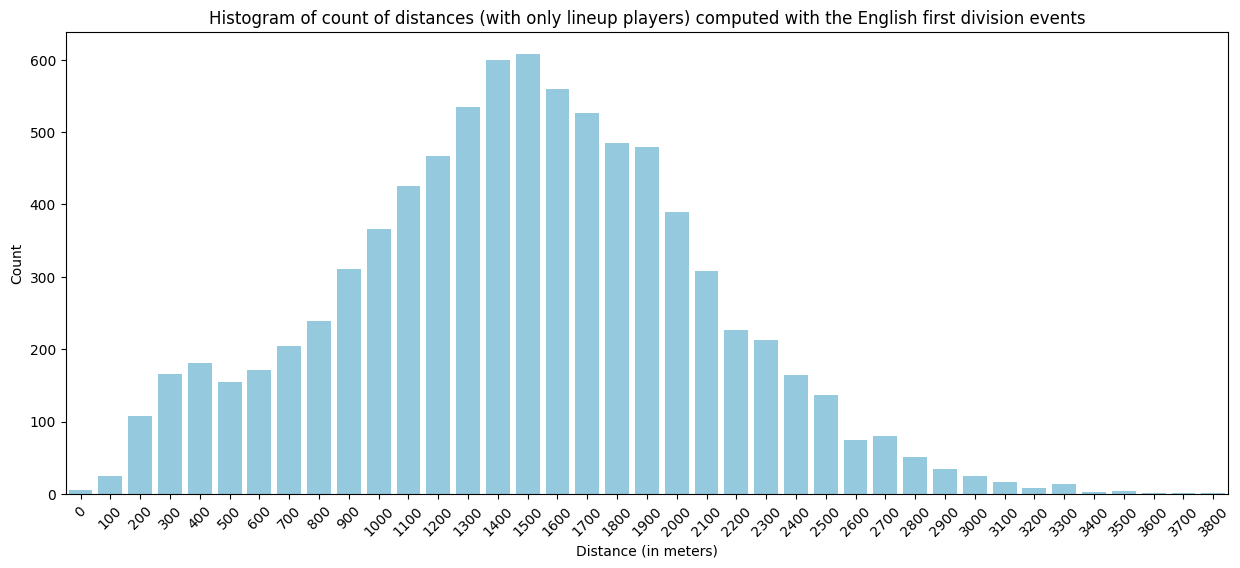

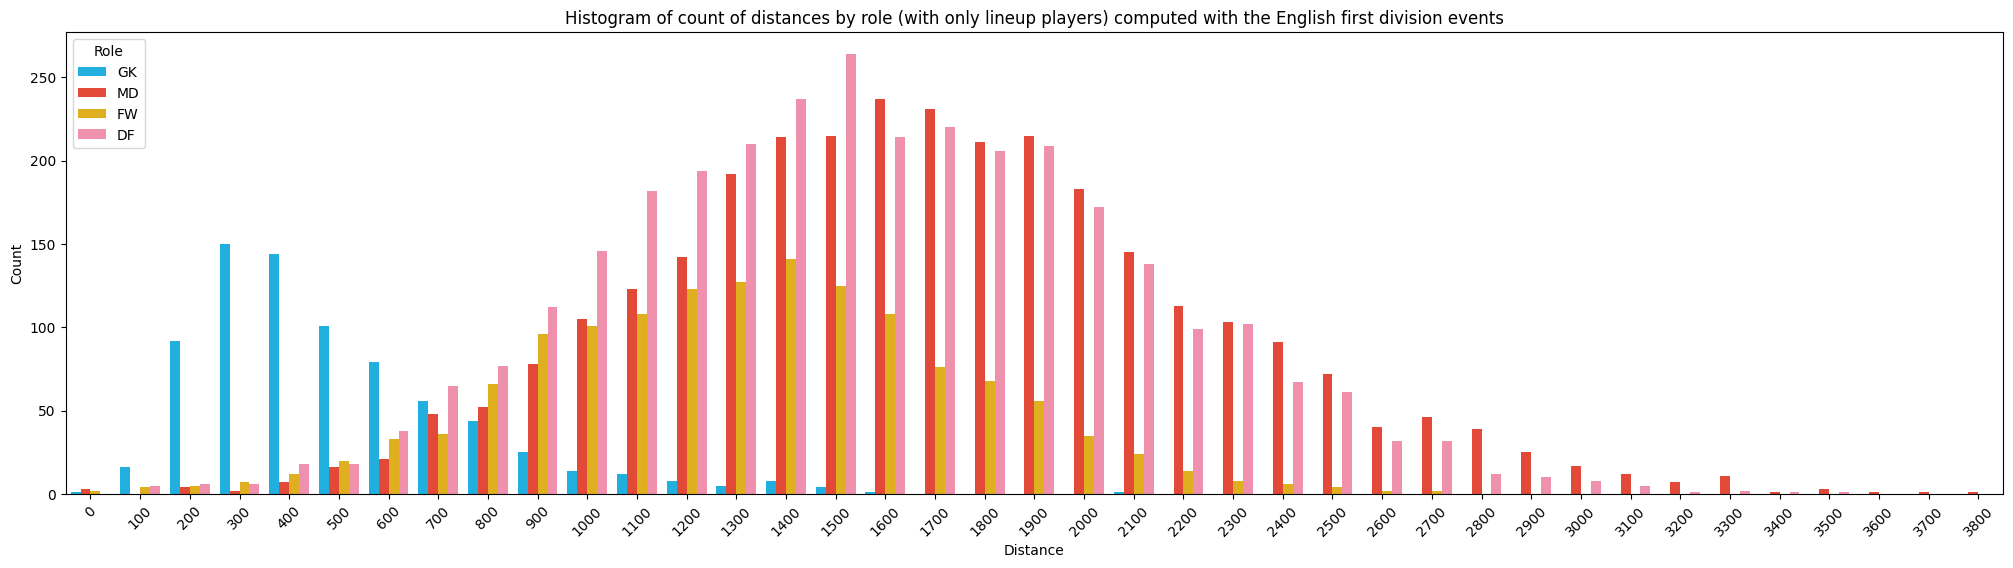

In [19]:
filtered_df, df1 = lineup_analysis(english_events_df, 'England', 'English first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for English first division


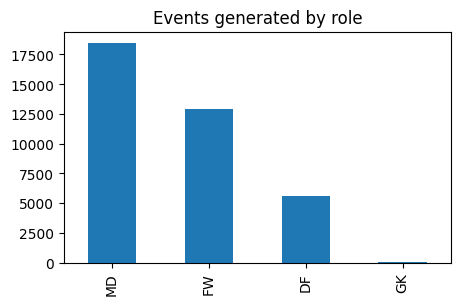

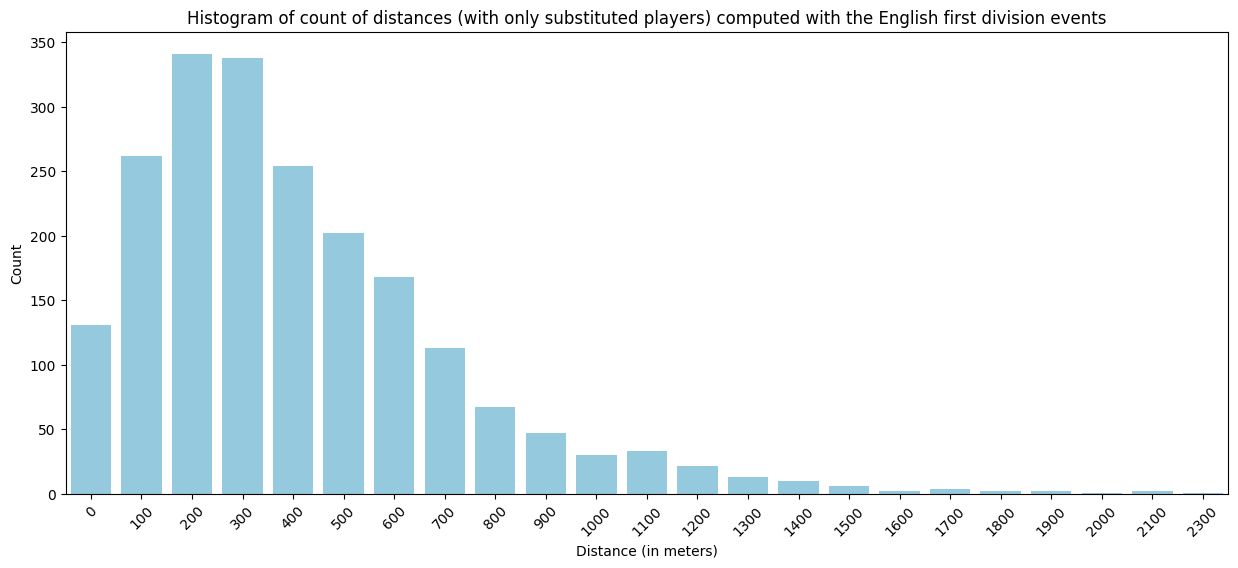

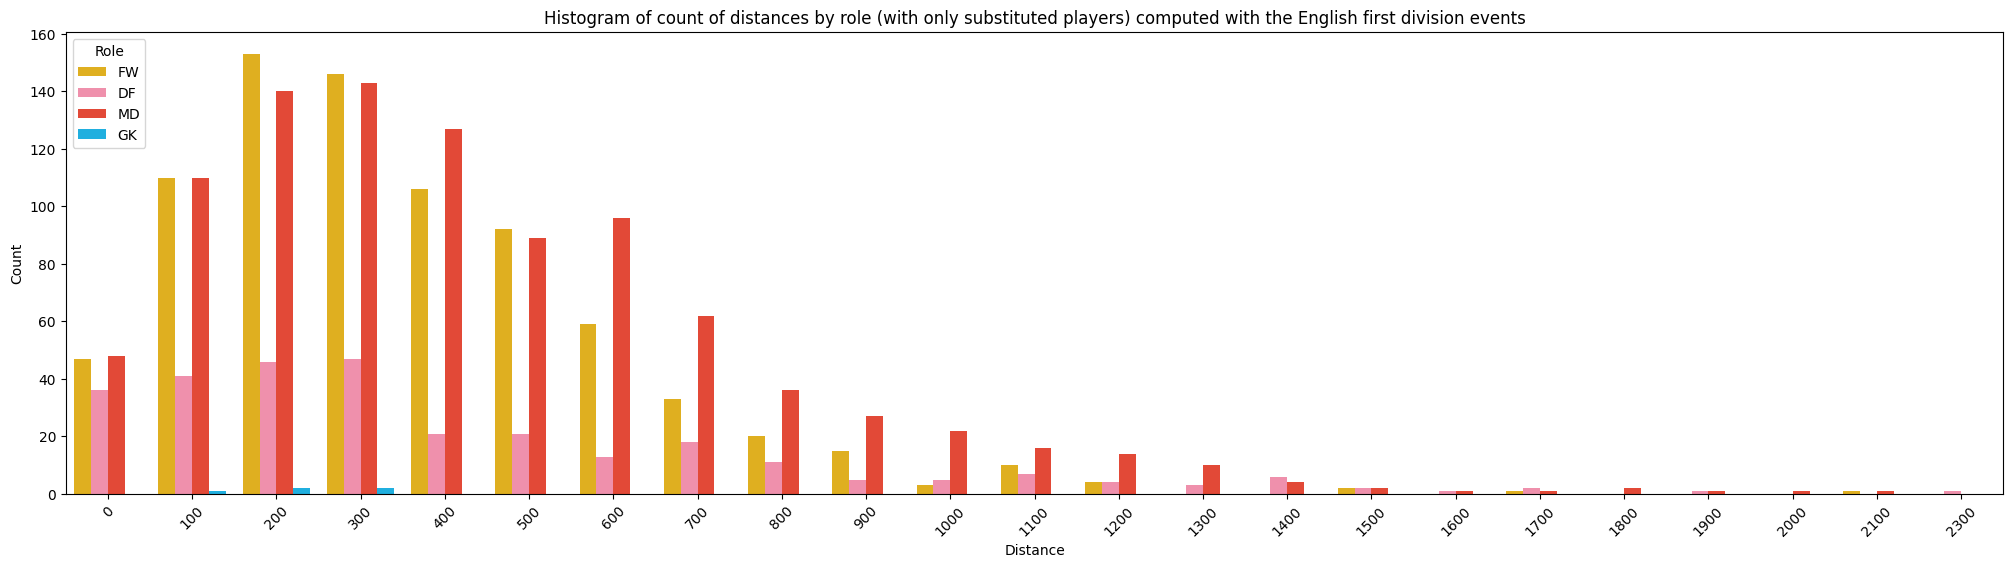

In [20]:
df1 = substitution_analysis(filtered_df, 'England', 'English first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## Spanish first division analysis

La Liga is renowned for its technical and tactical style of play, with teams often prioritizing possession-based football and intricate passing, which brings the midfielders to detain the highest number of generated events.<br>

General analysis for Spanish first division


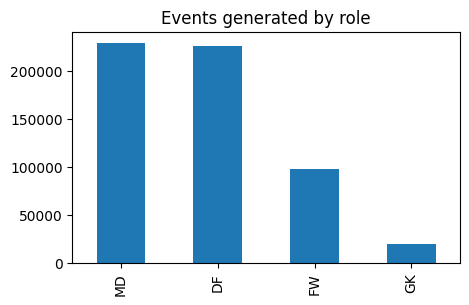

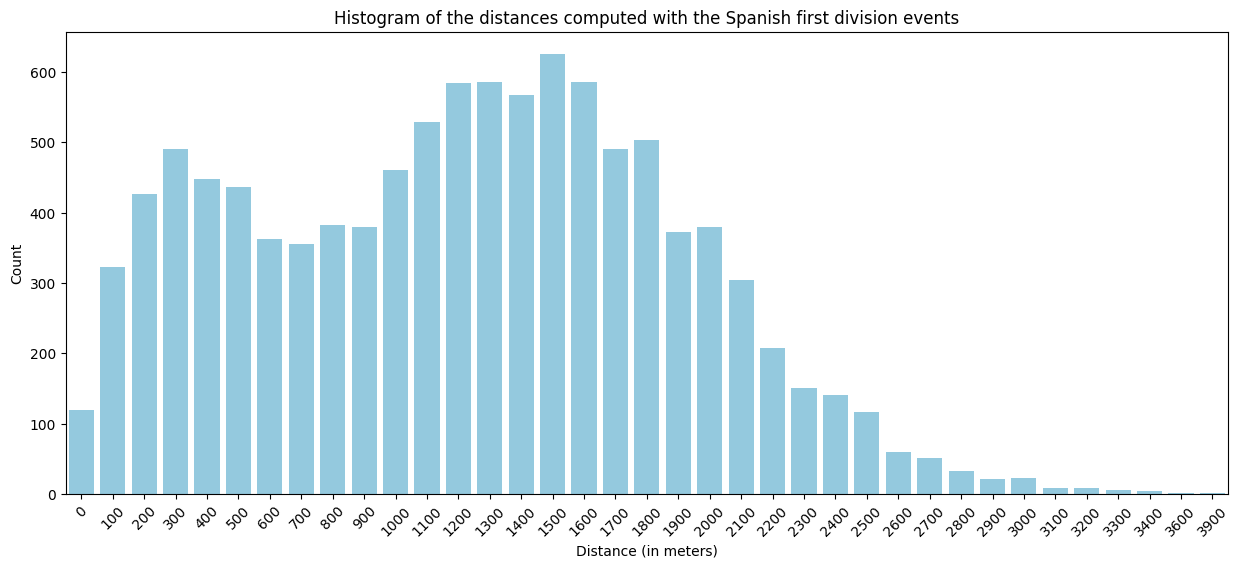

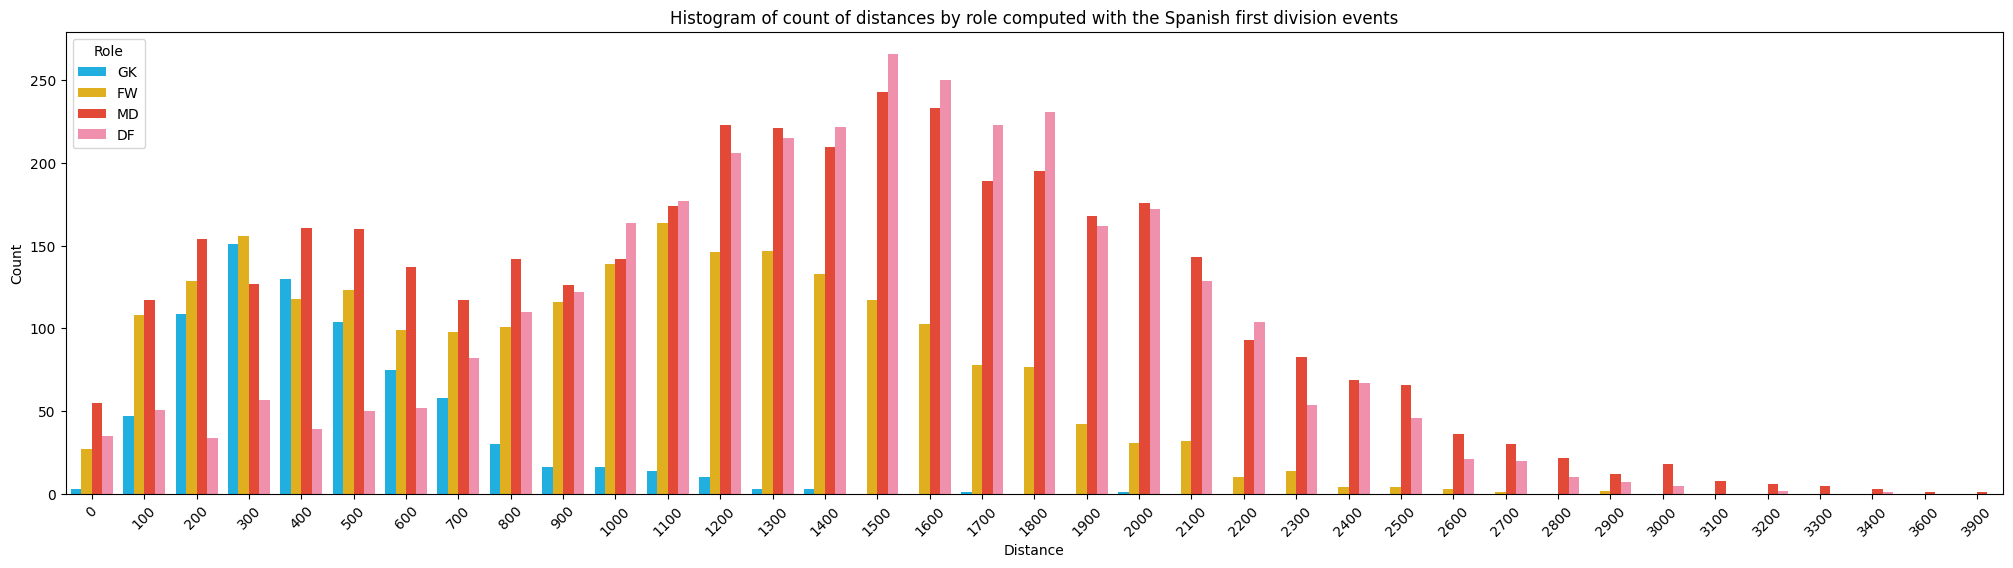

In [21]:
spanish_events_df, df1, df2 = general_analysis('Spain', 'Spanish first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for Spanish first division


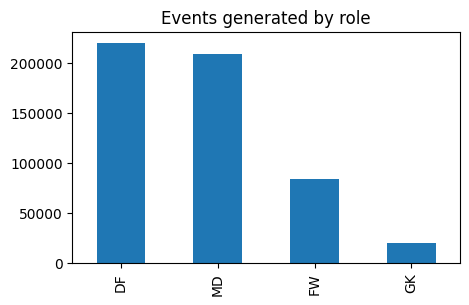

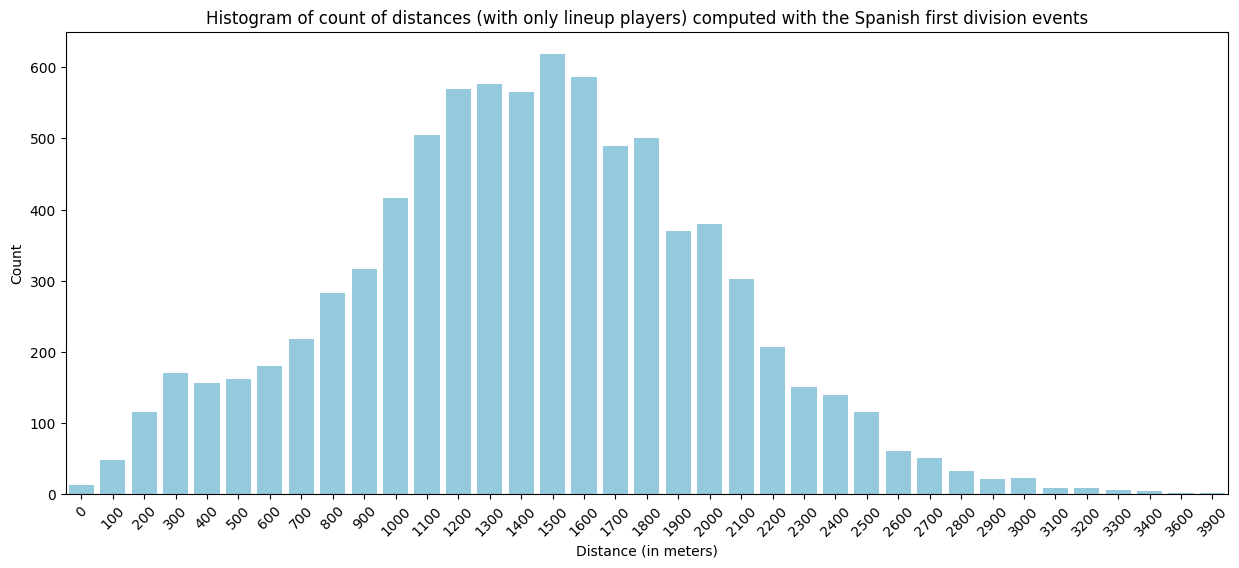

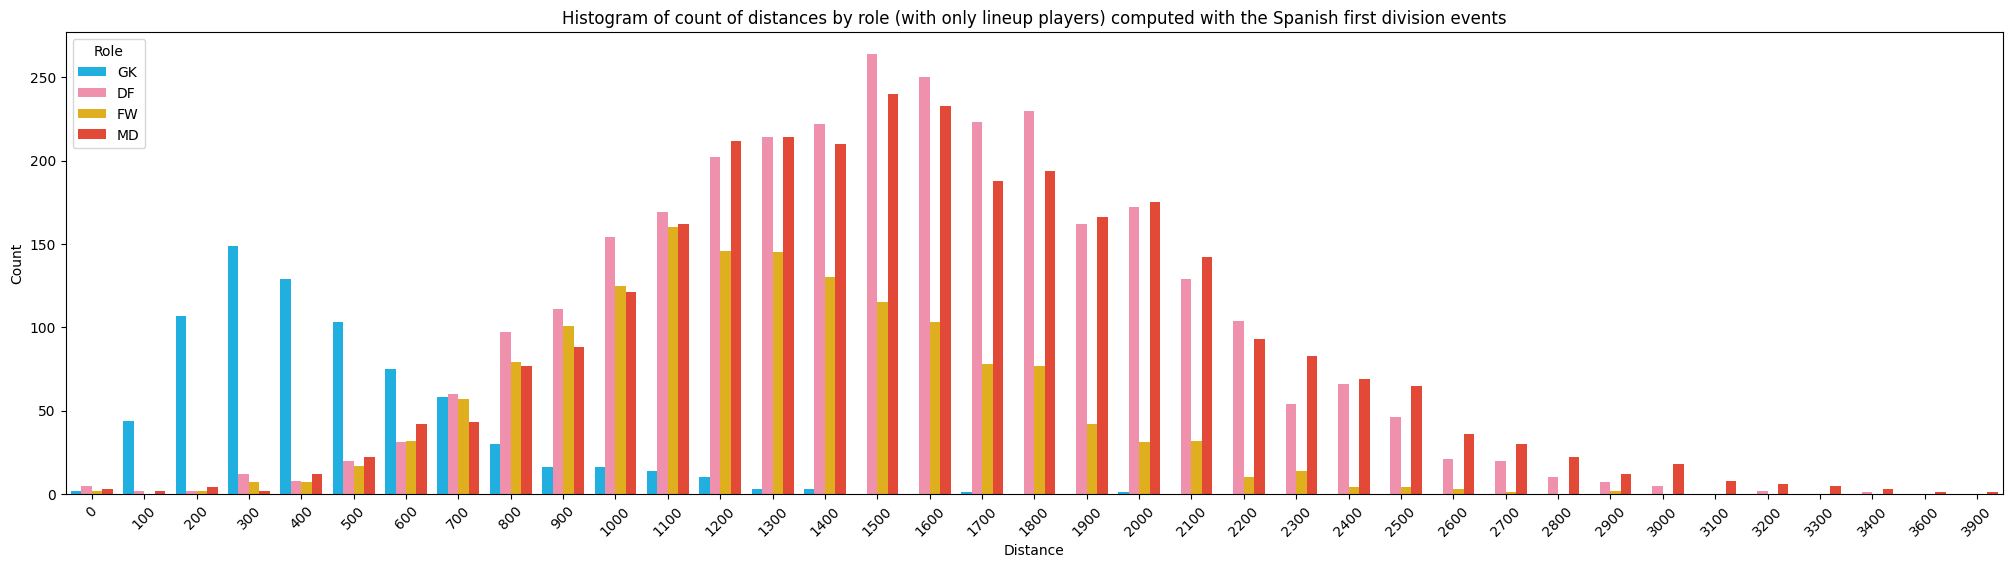

In [22]:
filtered_df, df1 = lineup_analysis(spanish_events_df, 'Spain', 'Spanish first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for Spanish first division


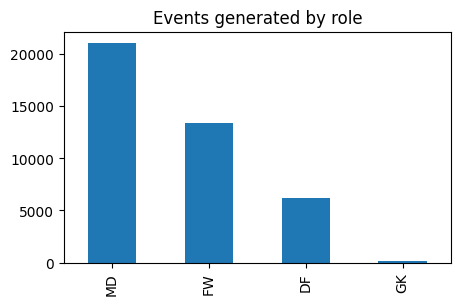

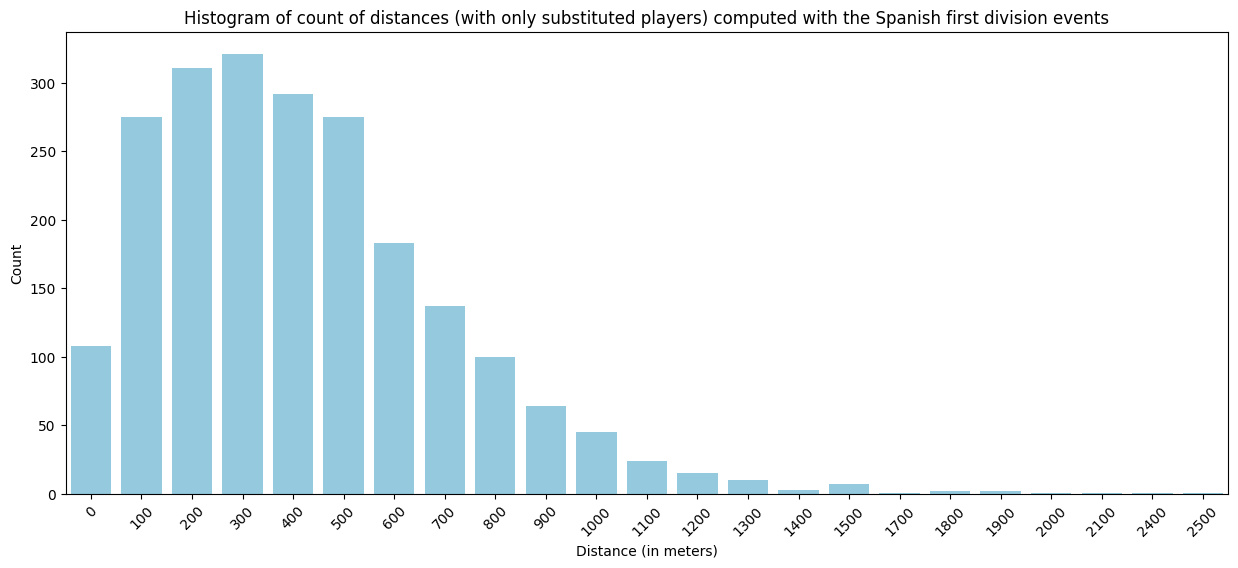

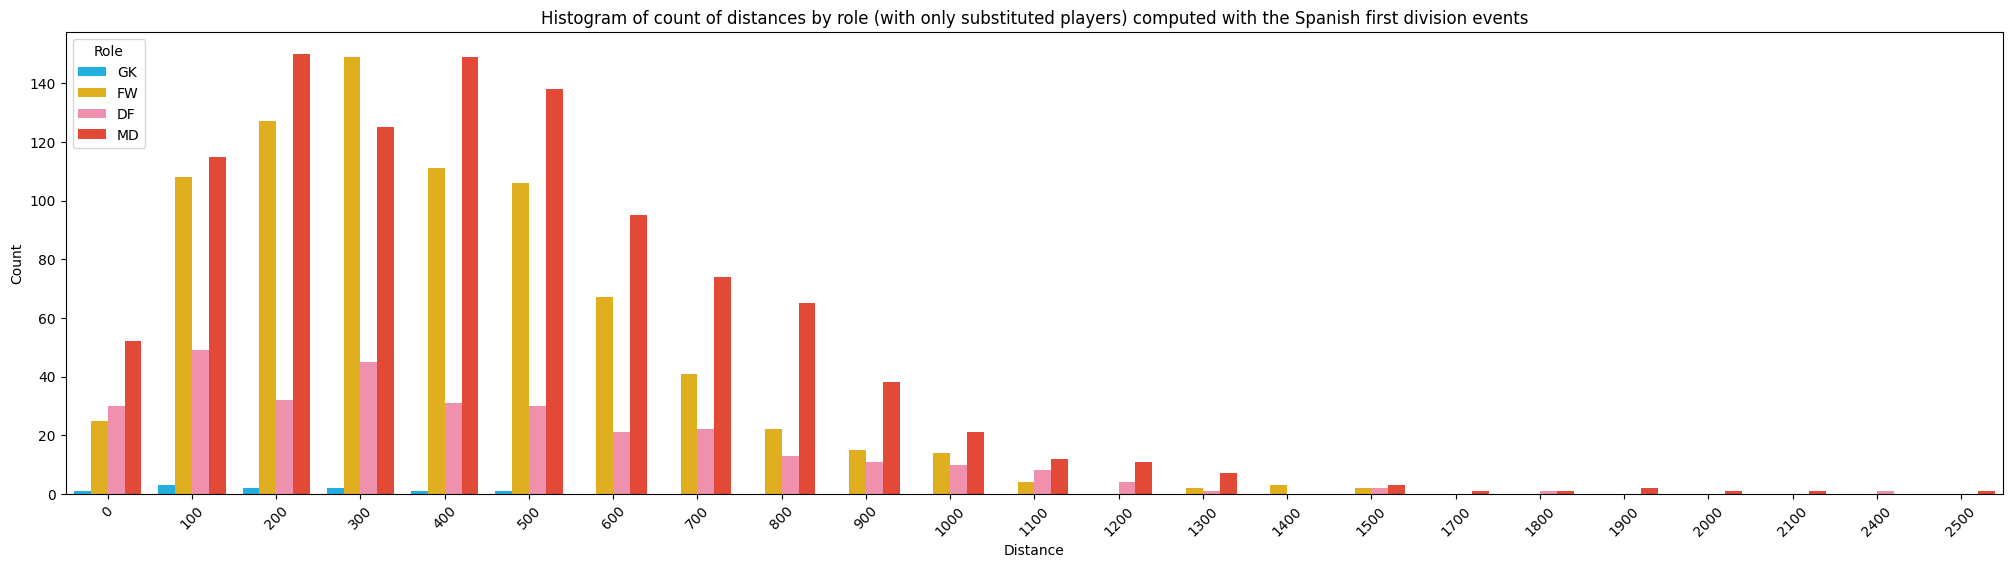

In [23]:
df1 = substitution_analysis(filtered_df, 'Spain', 'Spanish first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## German first division analysis

General analysis for German first division


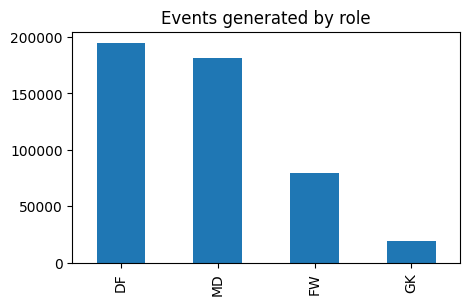

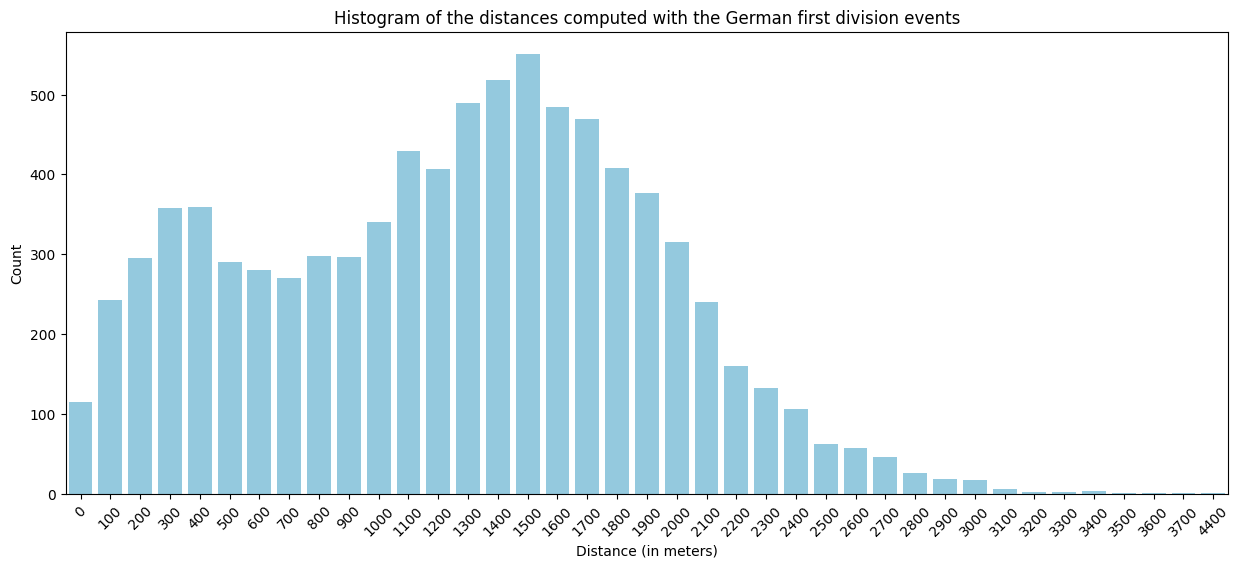

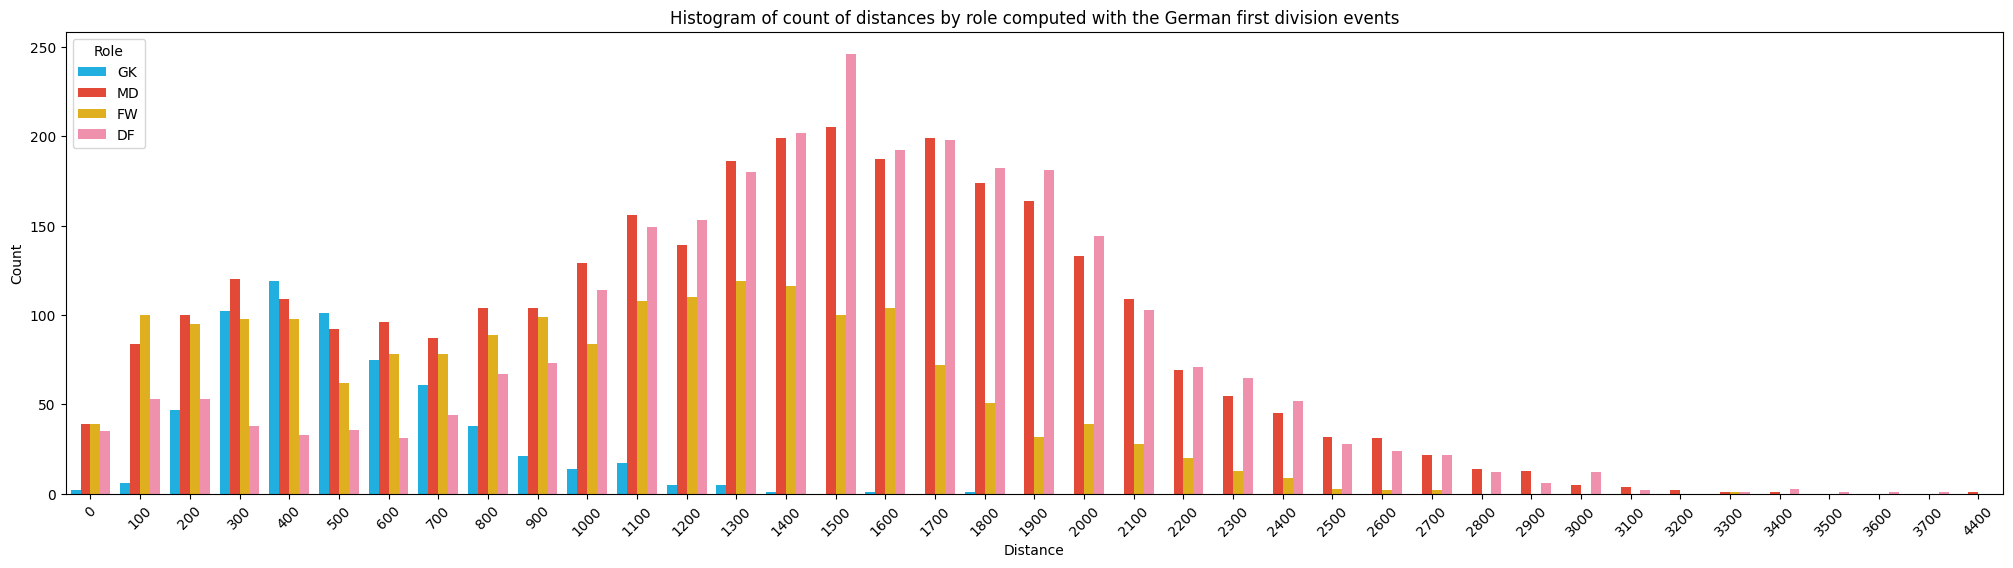

In [24]:
german_events_df, df1, df2 = general_analysis('Germany', 'German first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for German first division


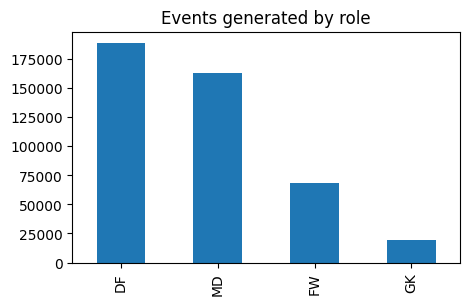

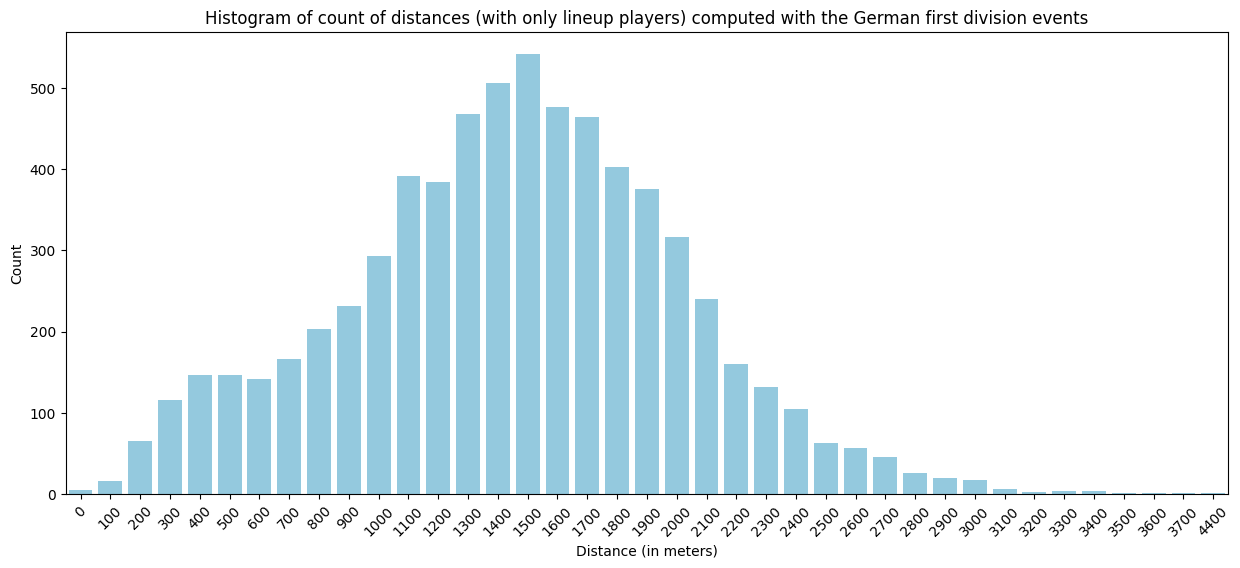

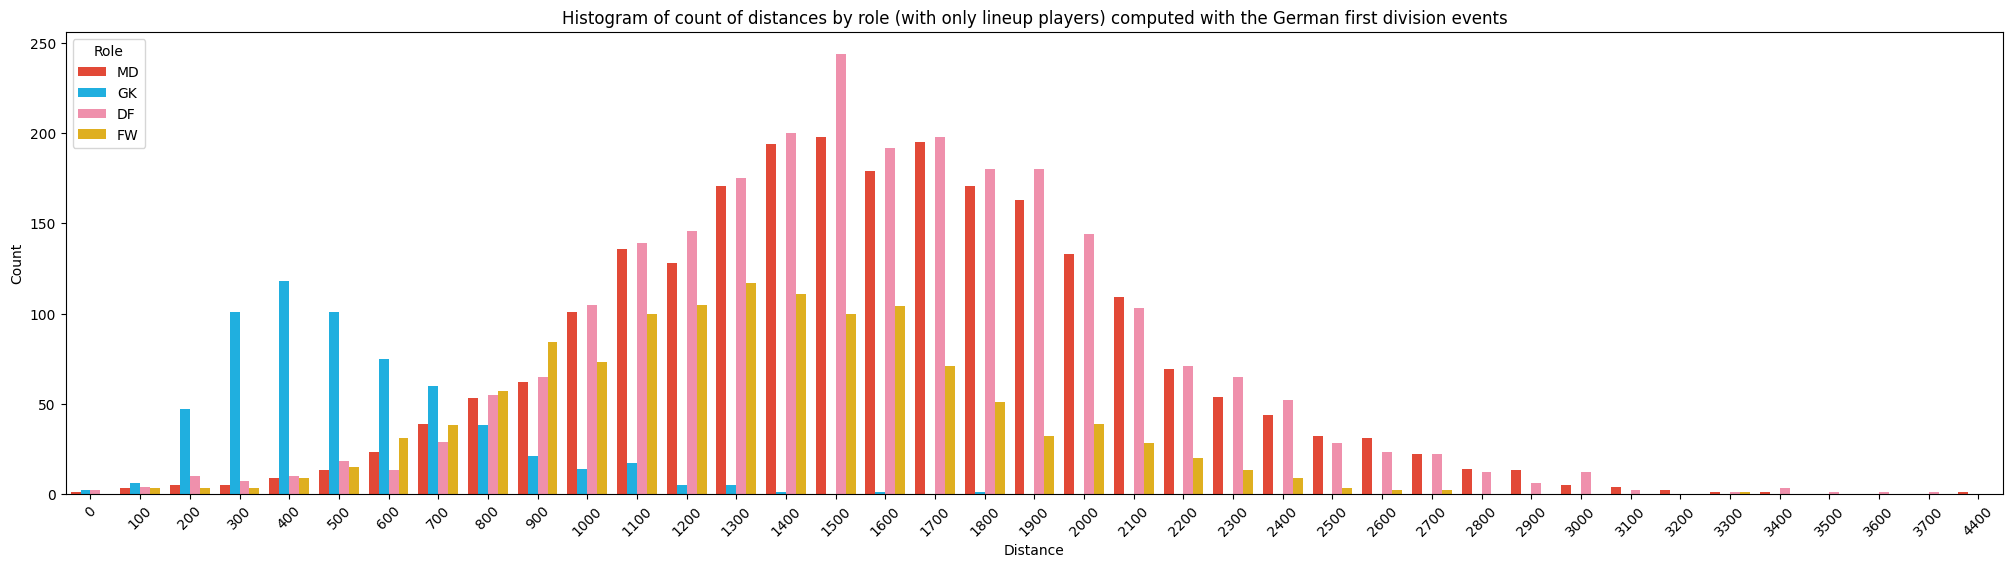

In [25]:
filtered_df, df1 = lineup_analysis(german_events_df, 'Germany', 'German first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for German first division


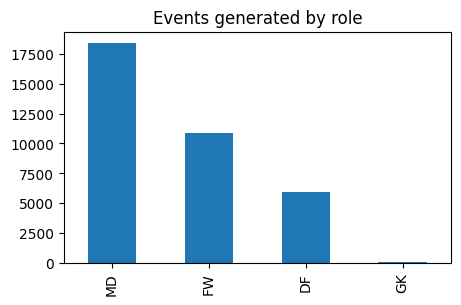

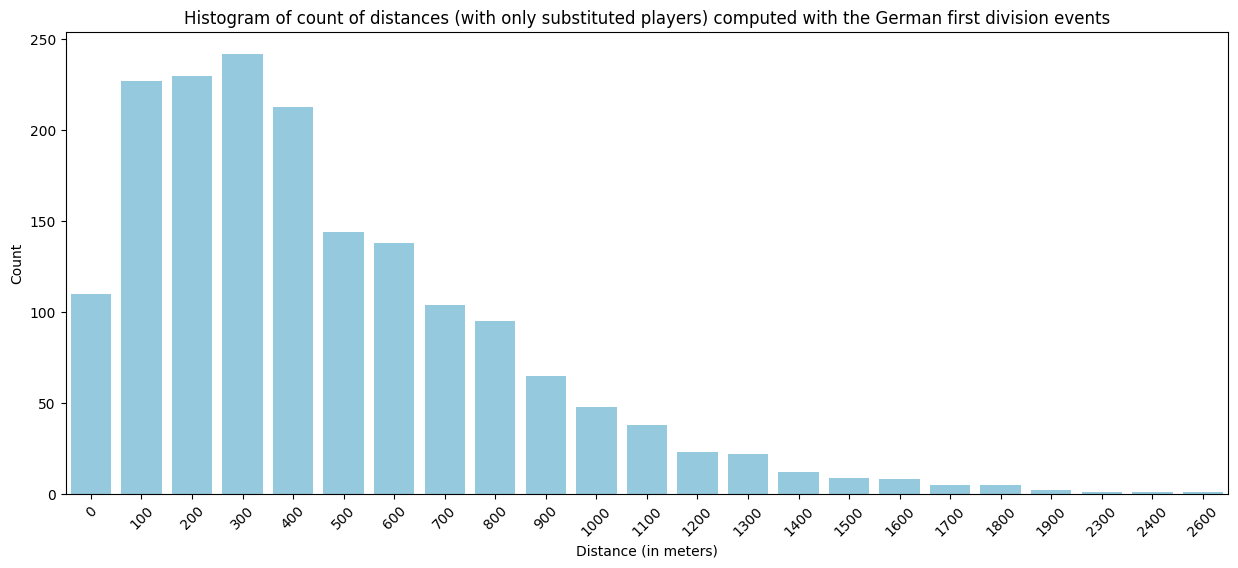

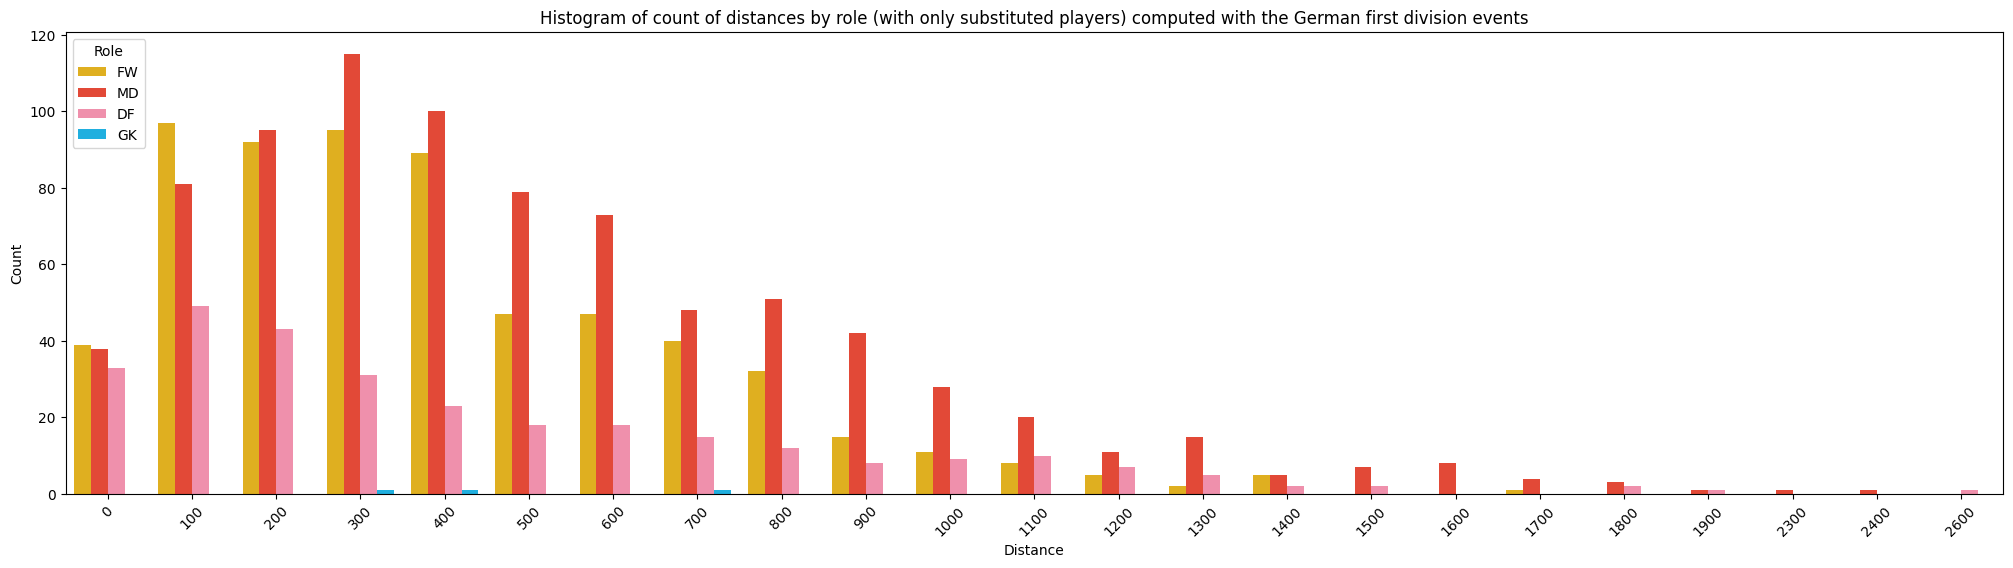

In [26]:
df1 = substitution_analysis(filtered_df, 'Germany', 'German first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## French first division analysis

General analysis for French first division


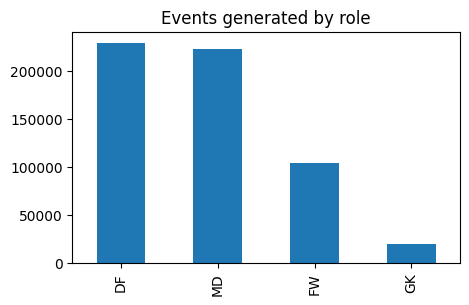

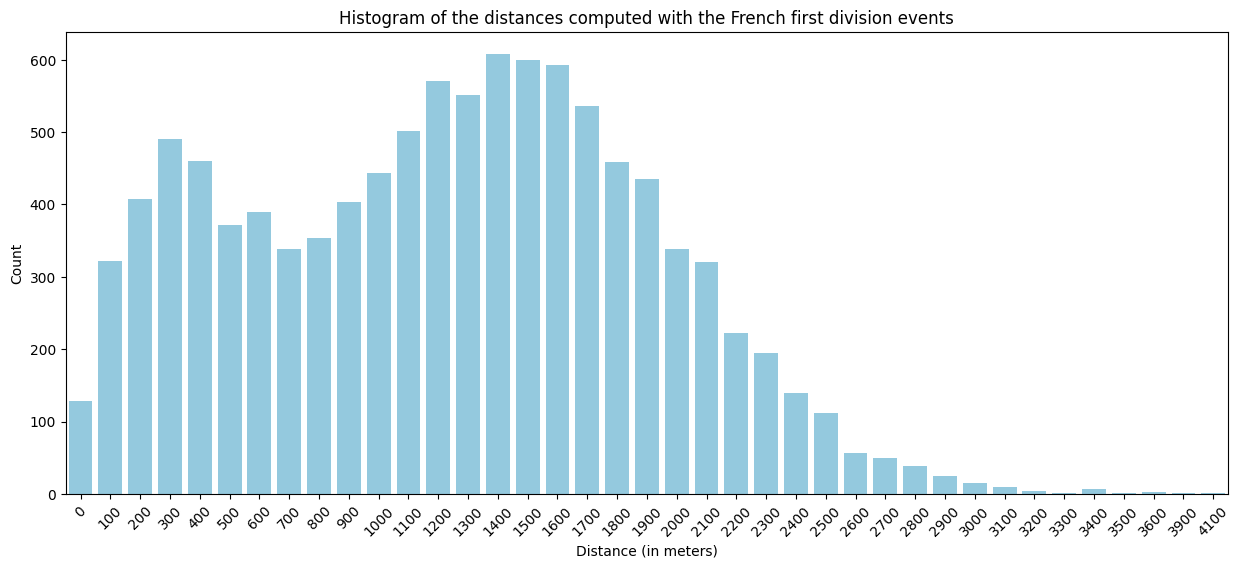

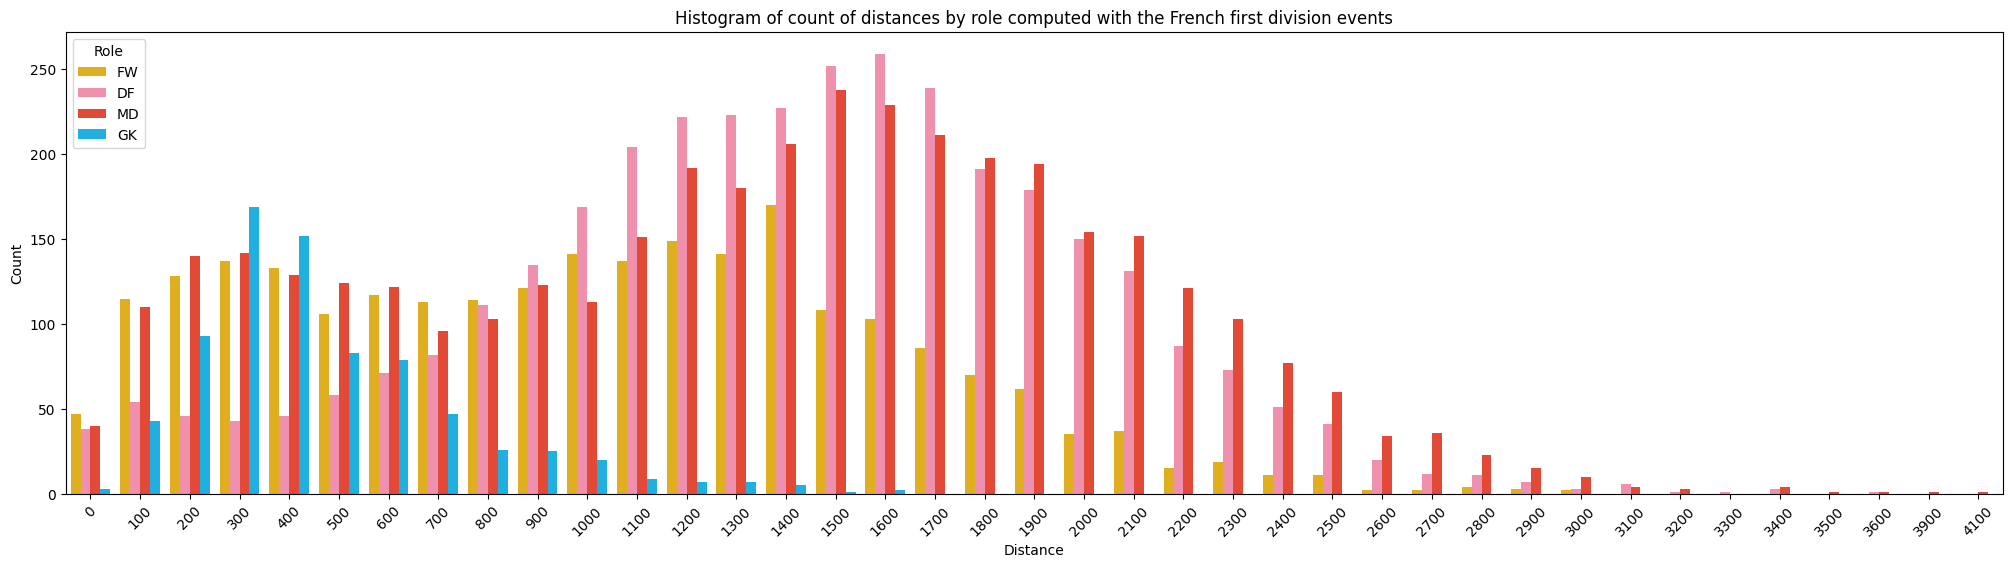

In [27]:
french_events_df, df1, df2 = general_analysis('France', 'French first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for French first division


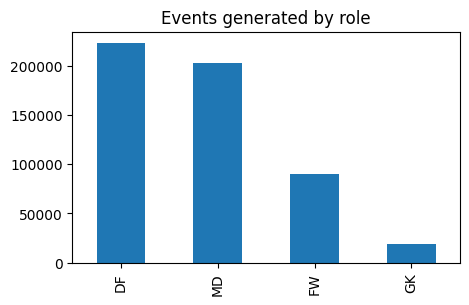

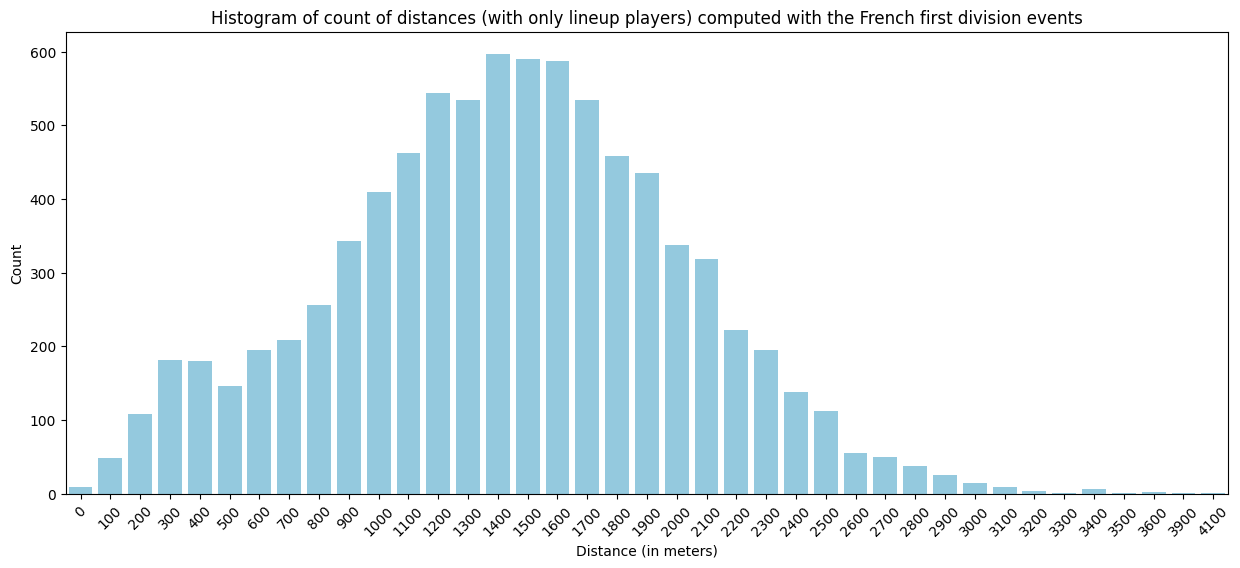

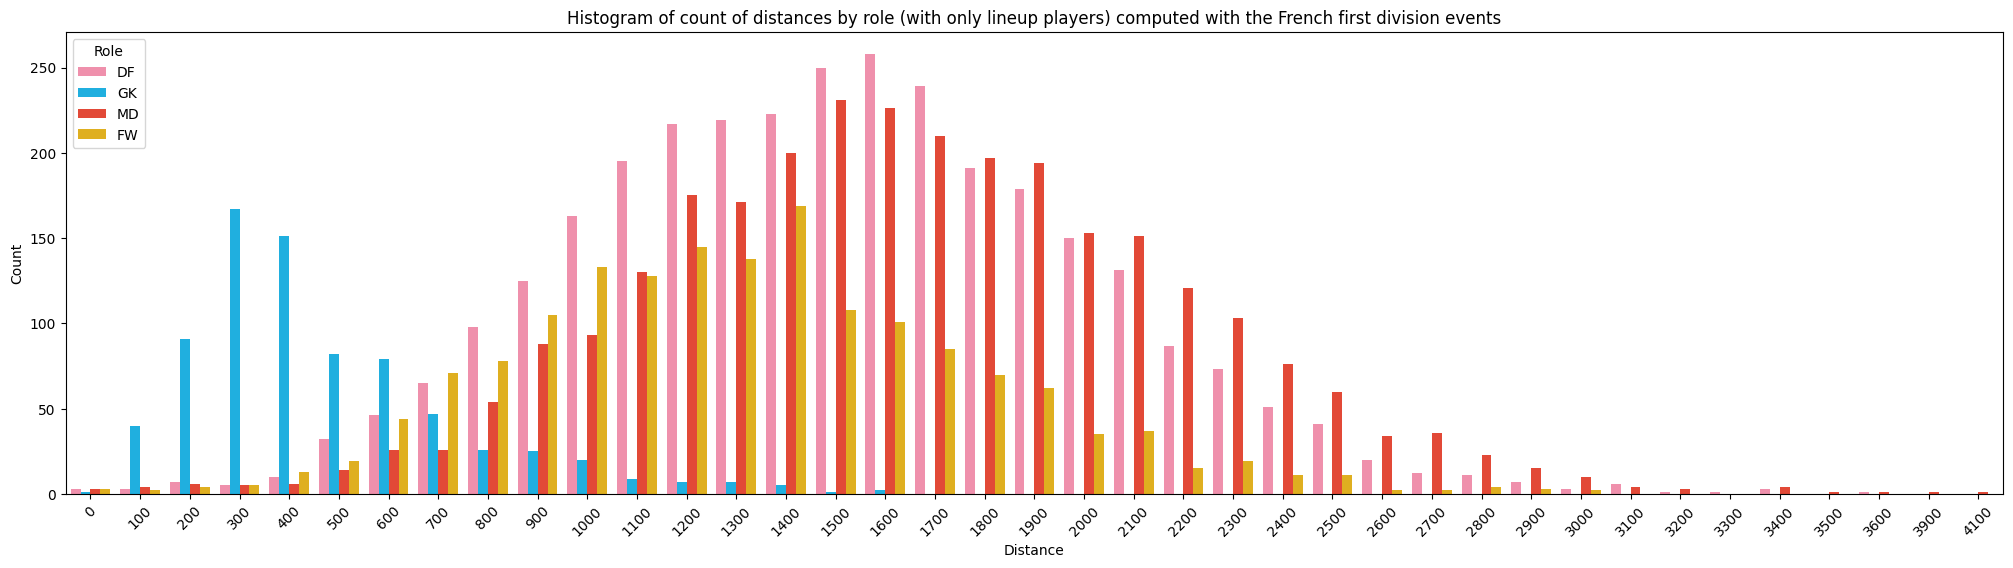

In [28]:
filtered_df, df1 = lineup_analysis(french_events_df, 'France', 'French first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for French first division


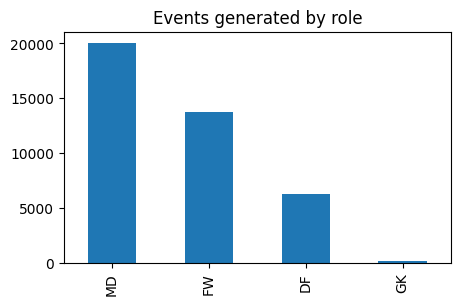

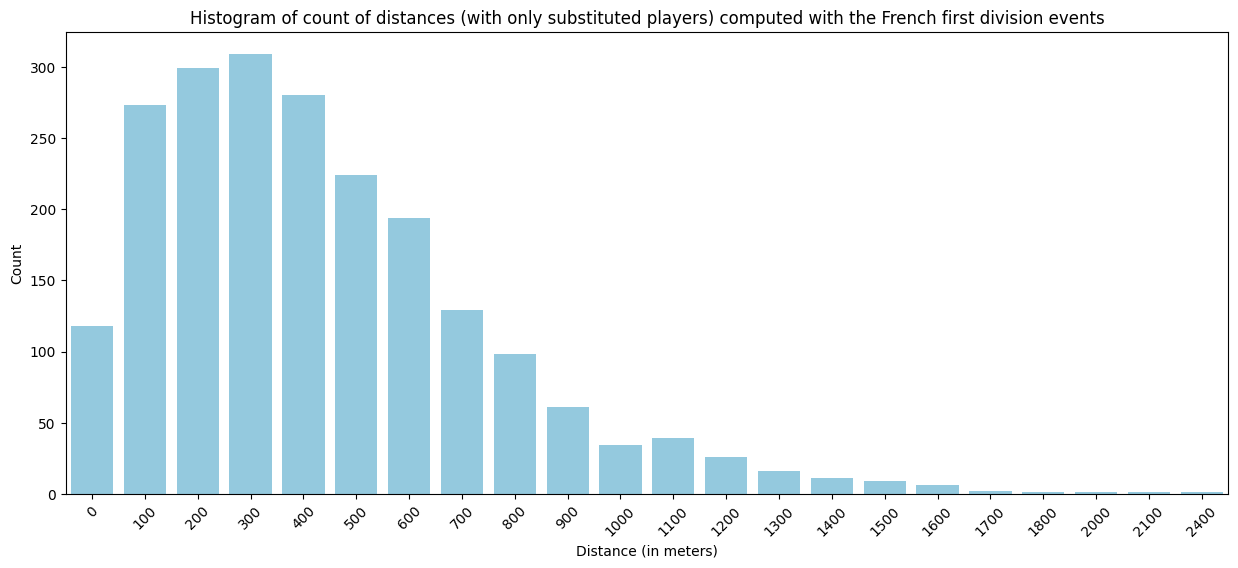

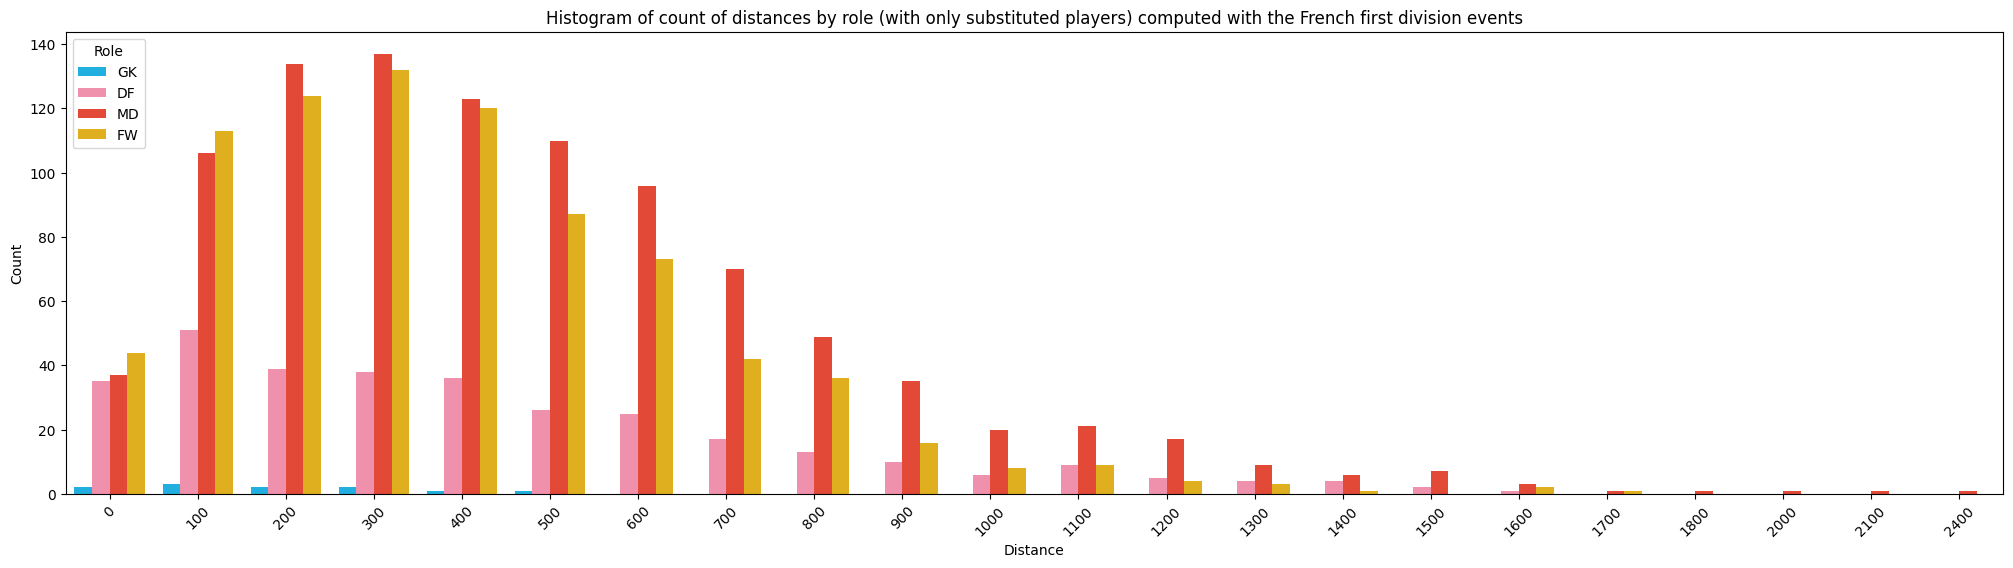

In [29]:
df1 = substitution_analysis(filtered_df, 'France', 'French first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## European Championship

In both European Championship and World Cup, the Gaussian distributions are less visible; this might be due to the fact that there are less played matches and because national teams tend to play mainly relying on long passes, causing a less players mobility.

General analysis for European Championship


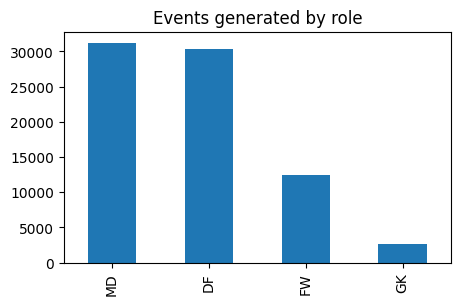

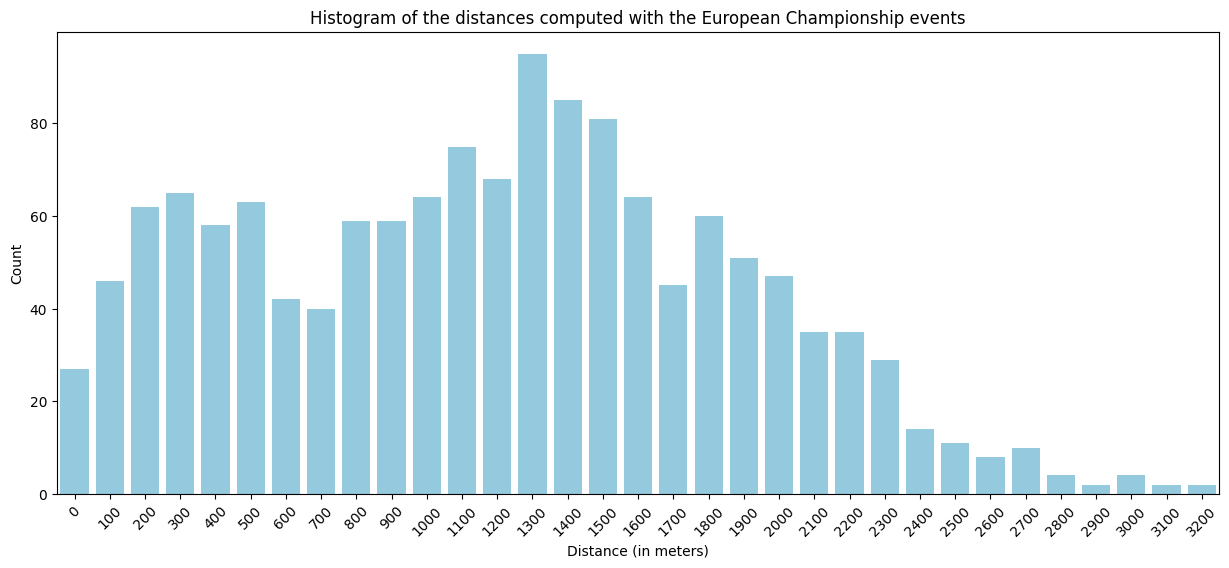

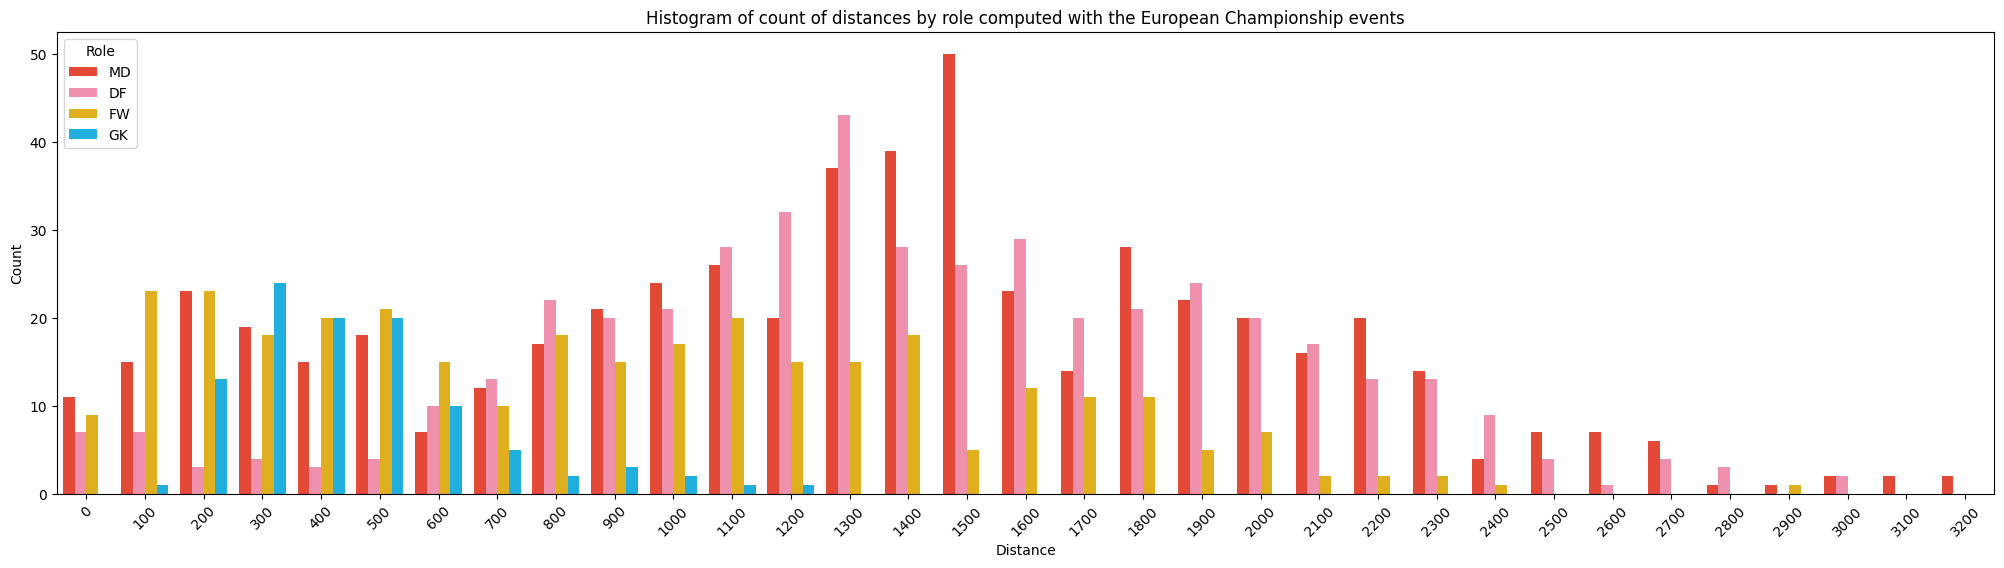

In [30]:
european_events_df, df1, df2 = general_analysis('European_Championship', 'European Championship')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for European Championship


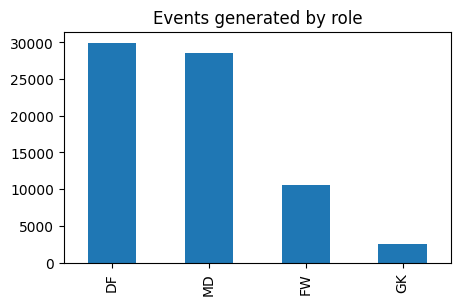

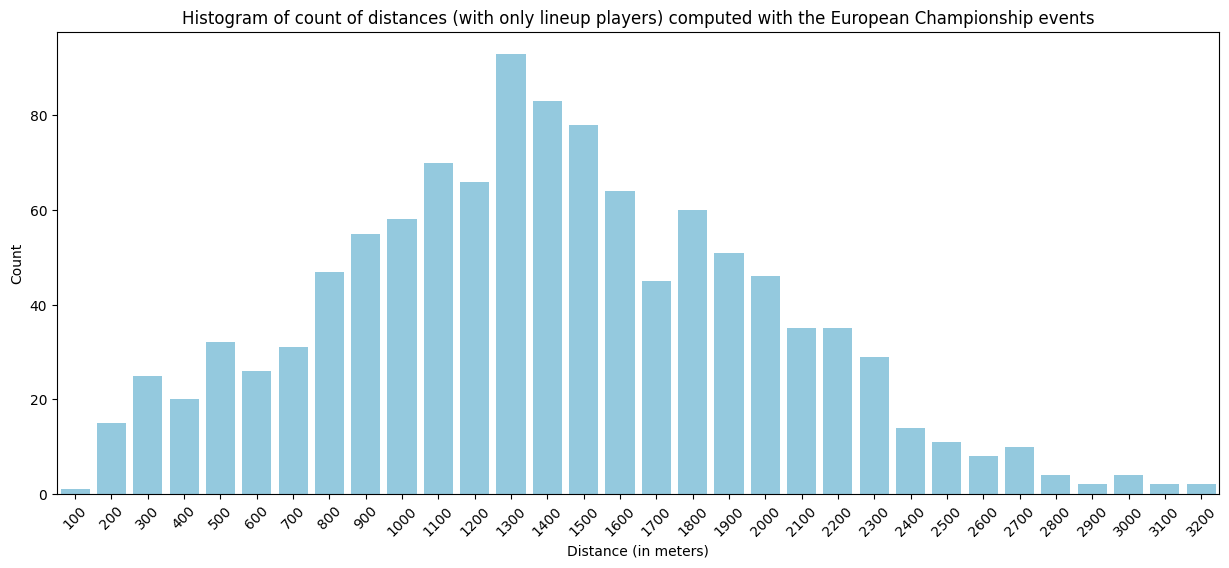

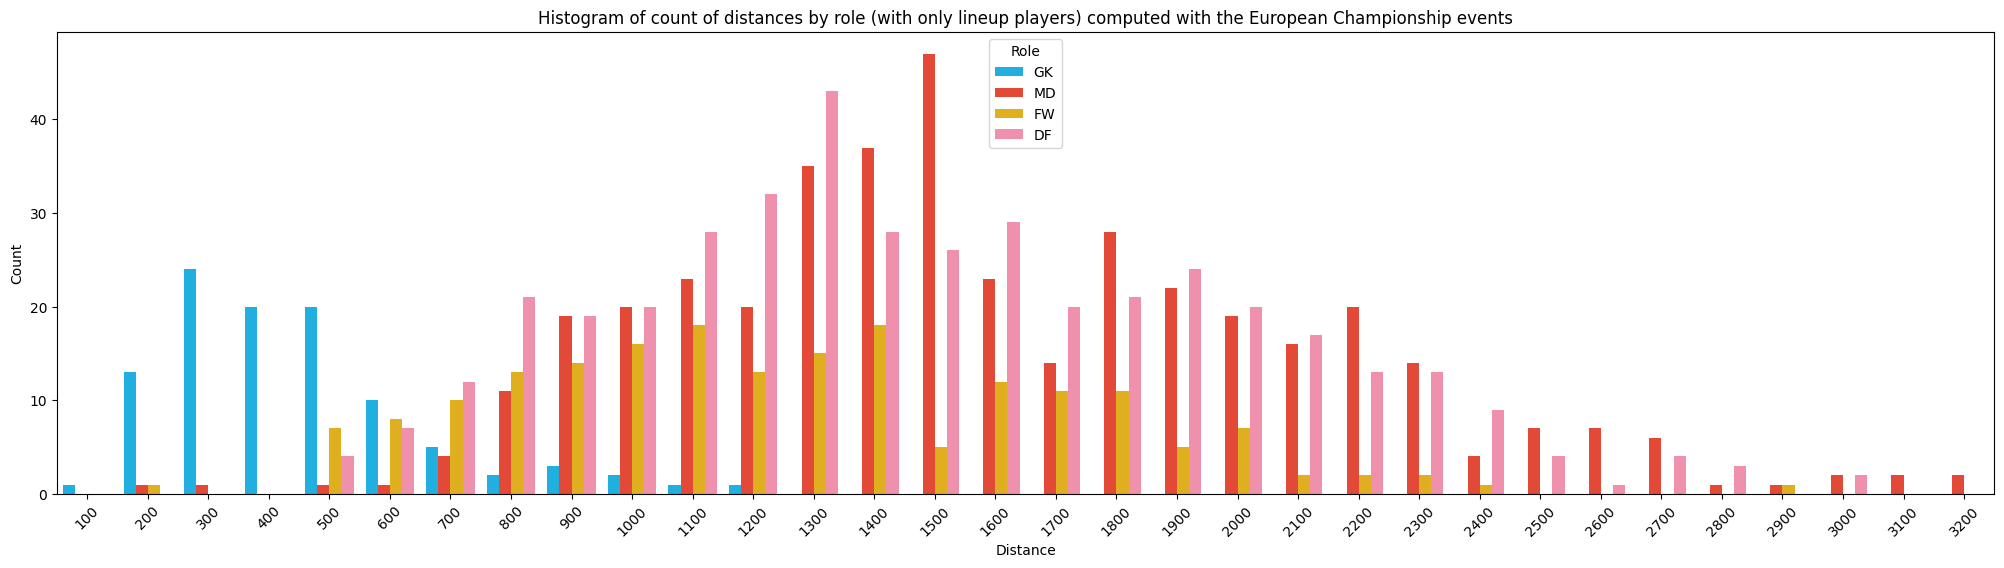

In [31]:
filtered_df, df1 = lineup_analysis(european_events_df, 'European_Championship', 'European Championship')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for European Championship


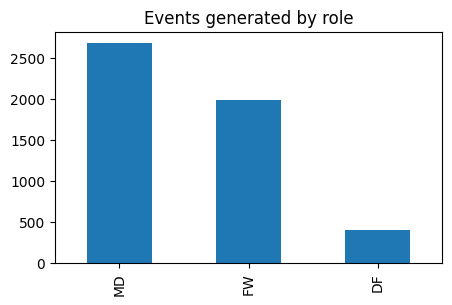

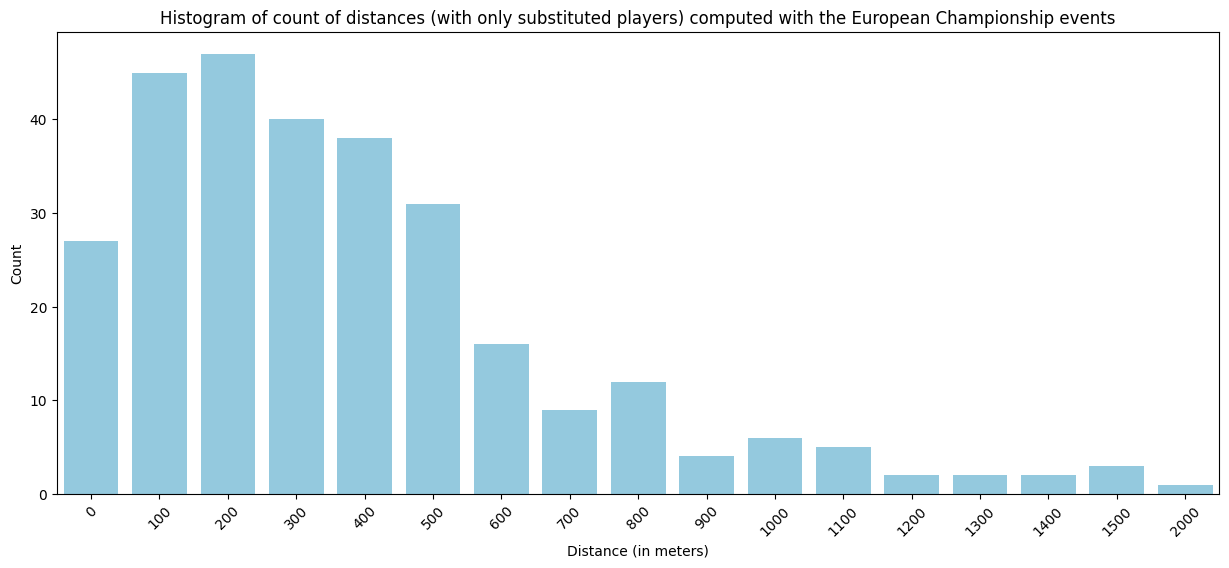

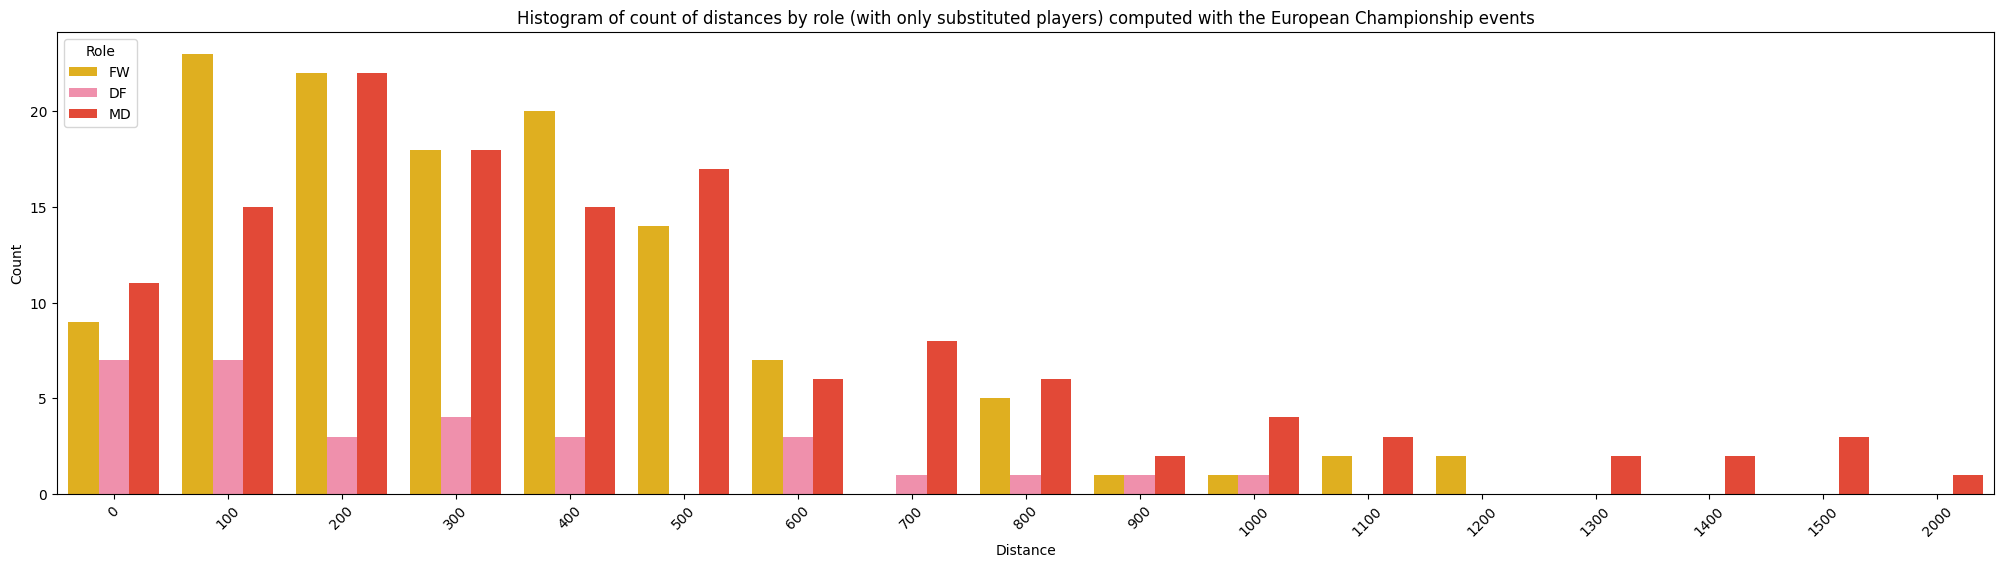

In [32]:
df1 = substitution_analysis(filtered_df, 'European_Championship', 'European Championship')

substitution_players_df = pd.concat([substitution_players_df, df1])

## World Cup

General analysis for World Cup


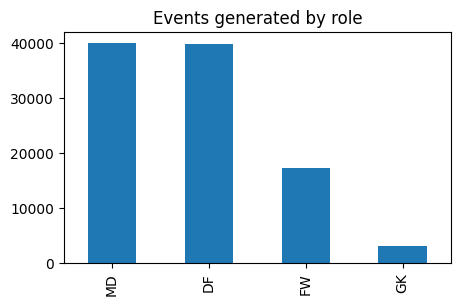

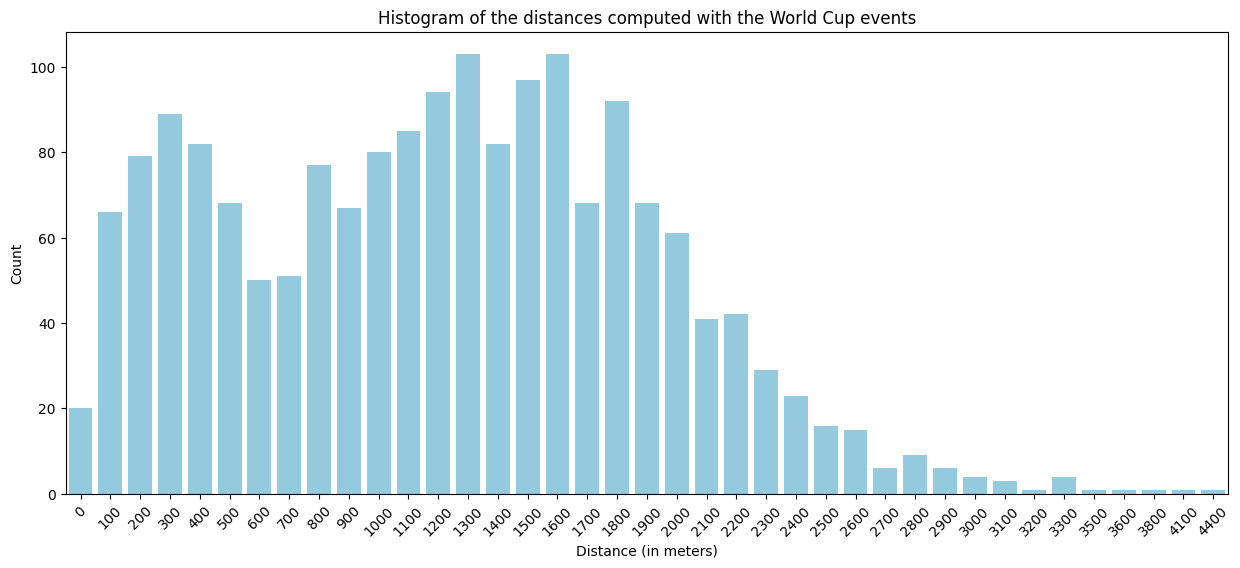

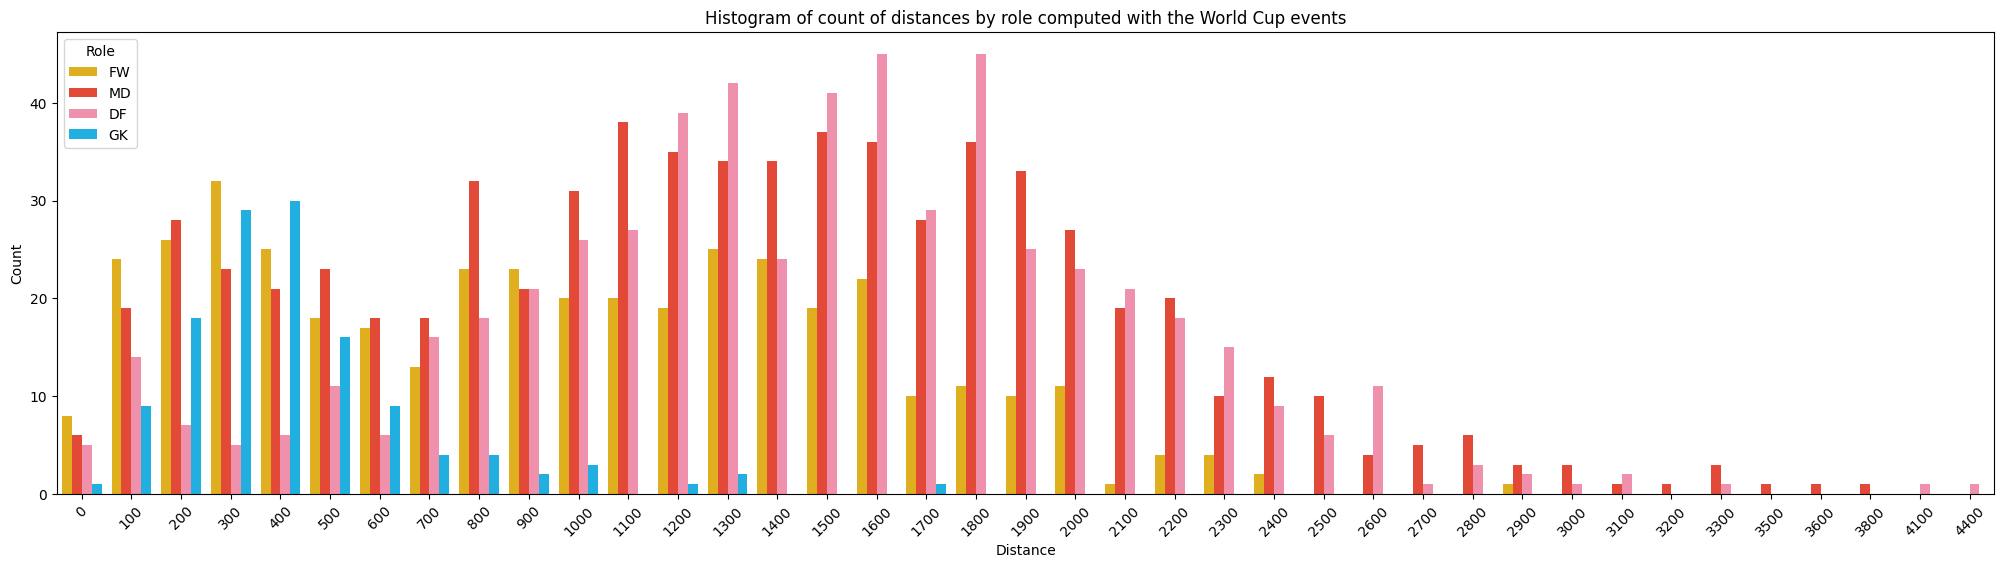

In [33]:
world_events_df, df1, df2 = general_analysis('World_Cup', 'World Cup')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for World_Cup


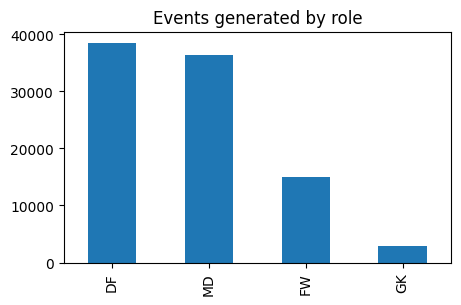

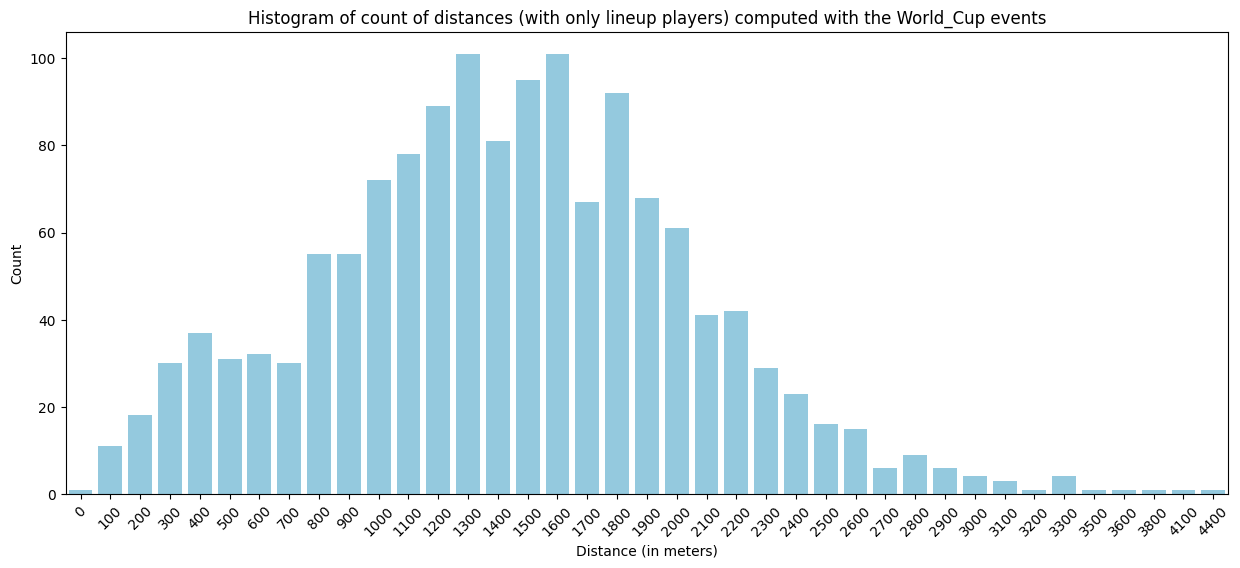

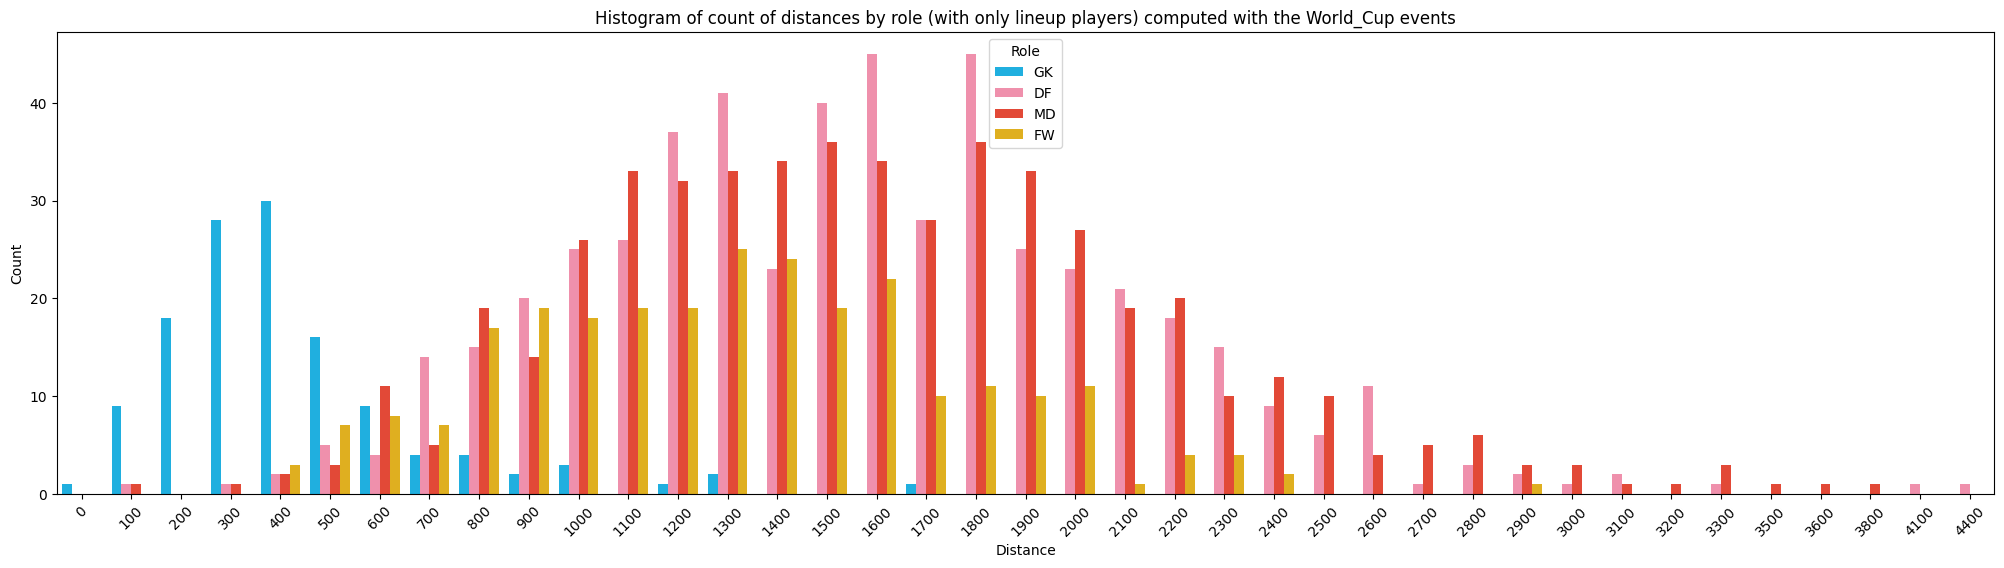

In [34]:
filtered_df, df1 = lineup_analysis(world_events_df, 'World_Cup', 'World_Cup')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for World Cup


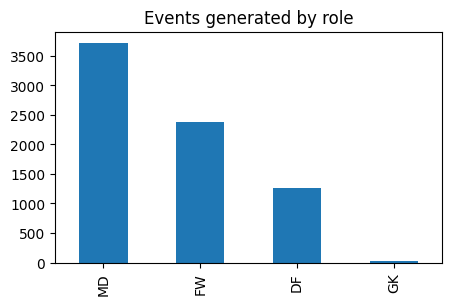

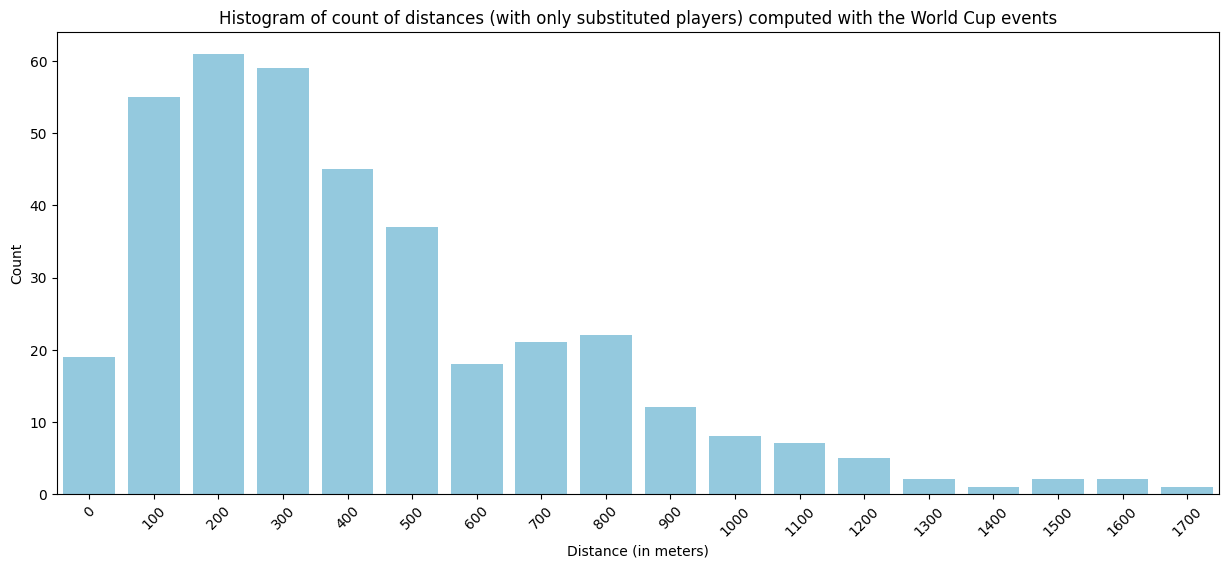

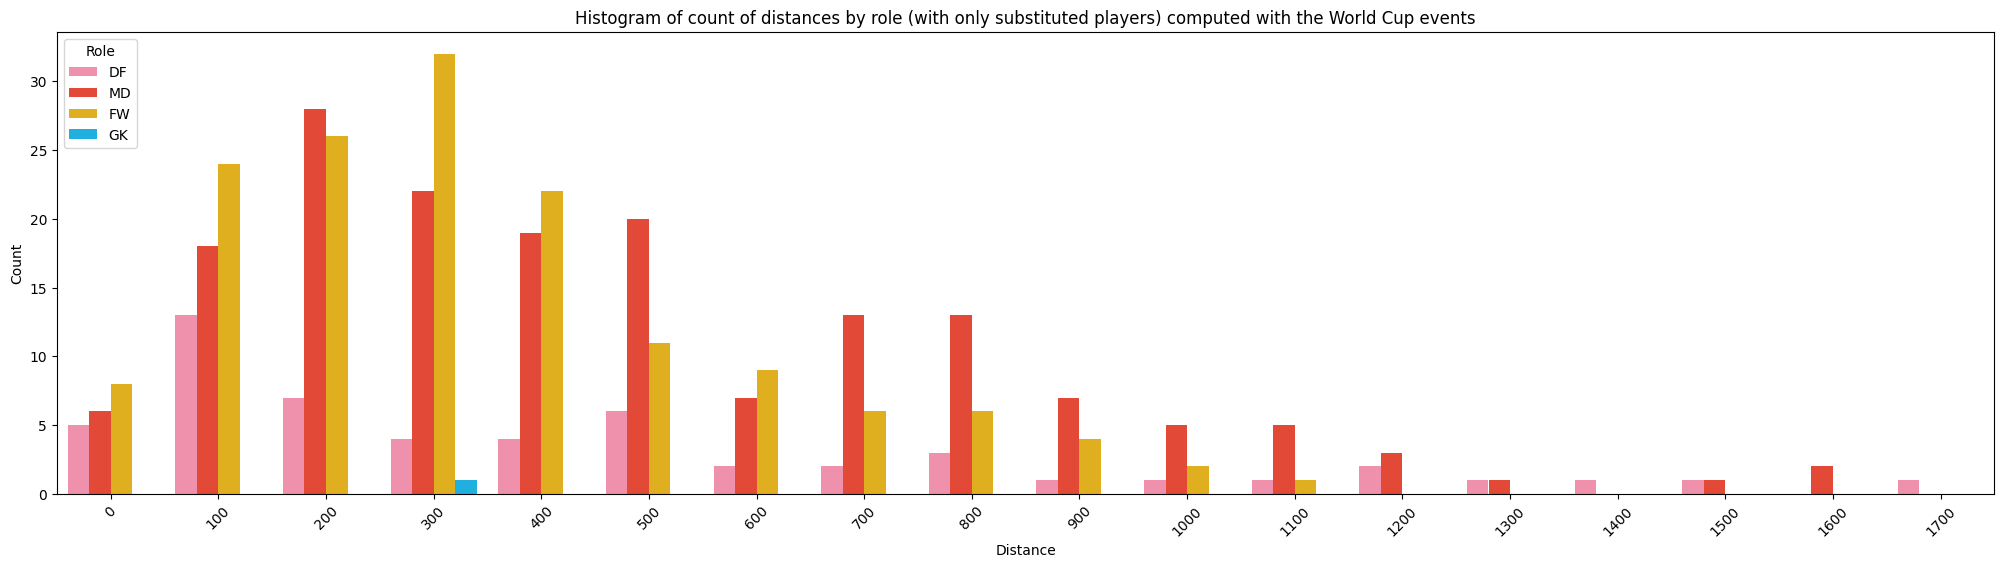

In [35]:
df1 = substitution_analysis(filtered_df, 'World_Cup', 'World Cup')

substitution_players_df = pd.concat([substitution_players_df, df1])

## Total distances

General analysis


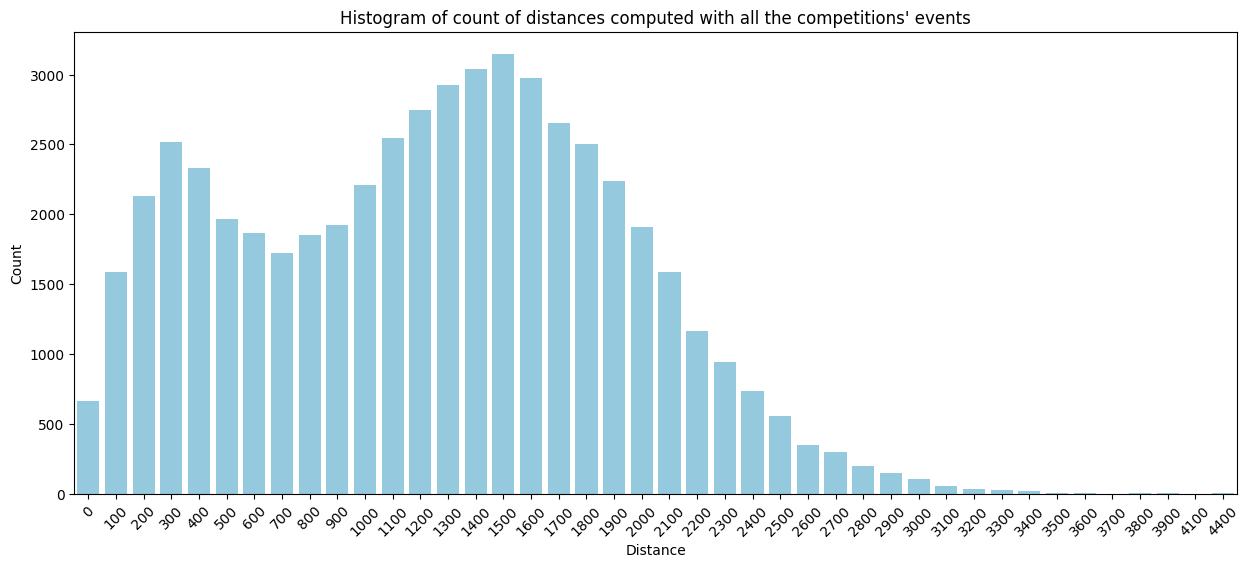

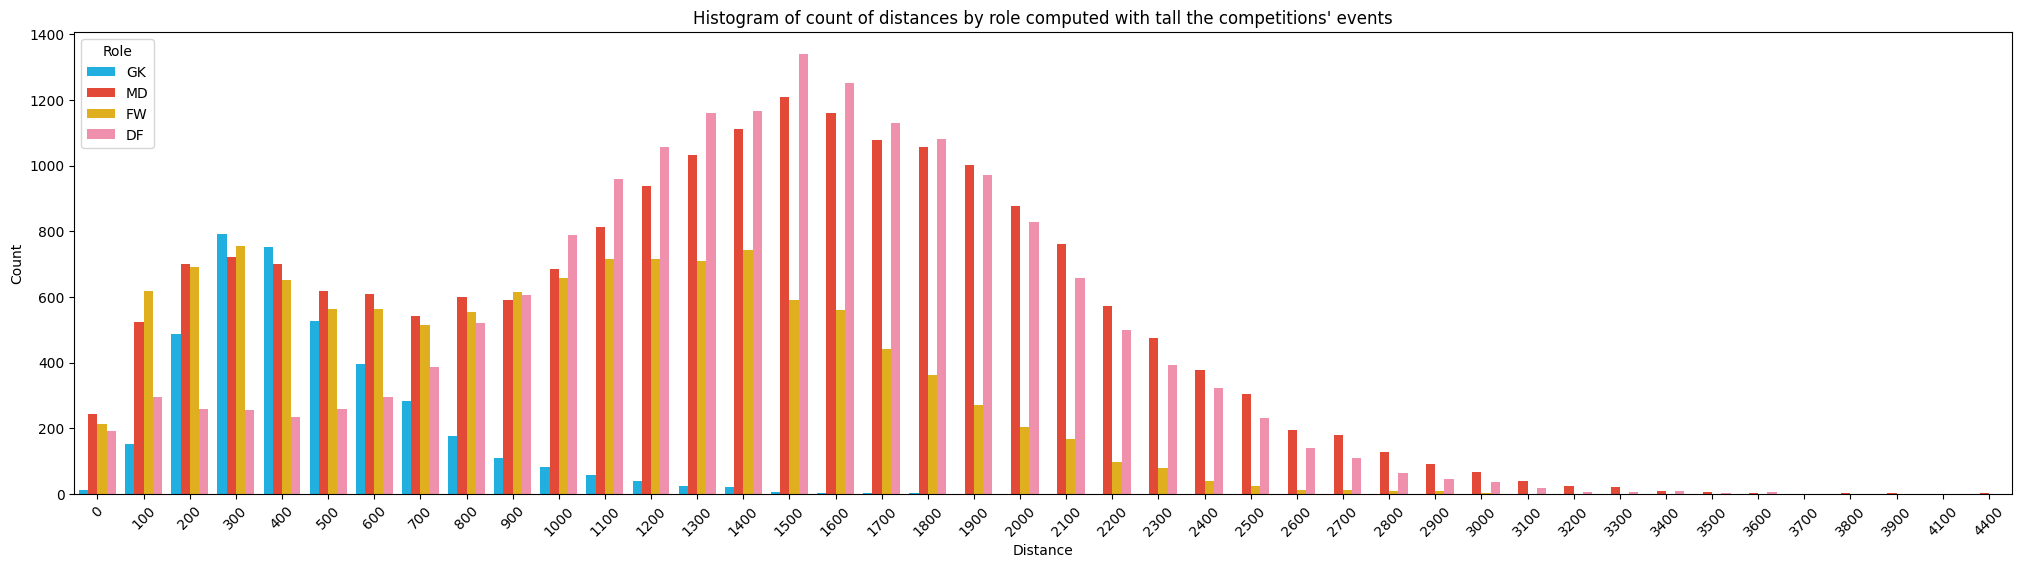

In [36]:
total_analysis()

Lineup analysis


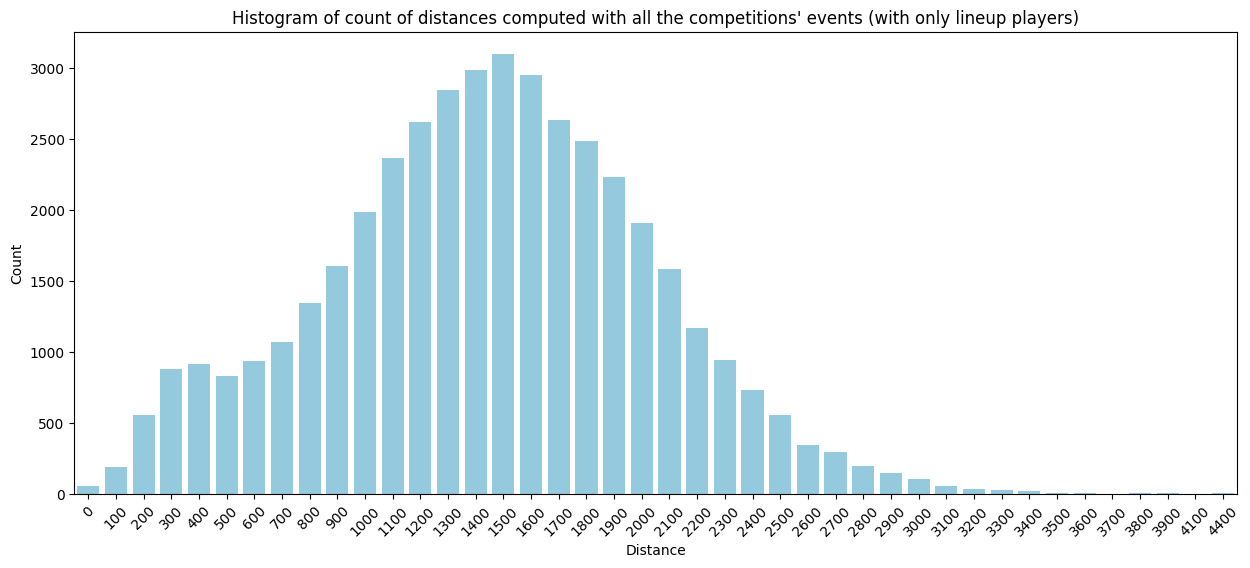

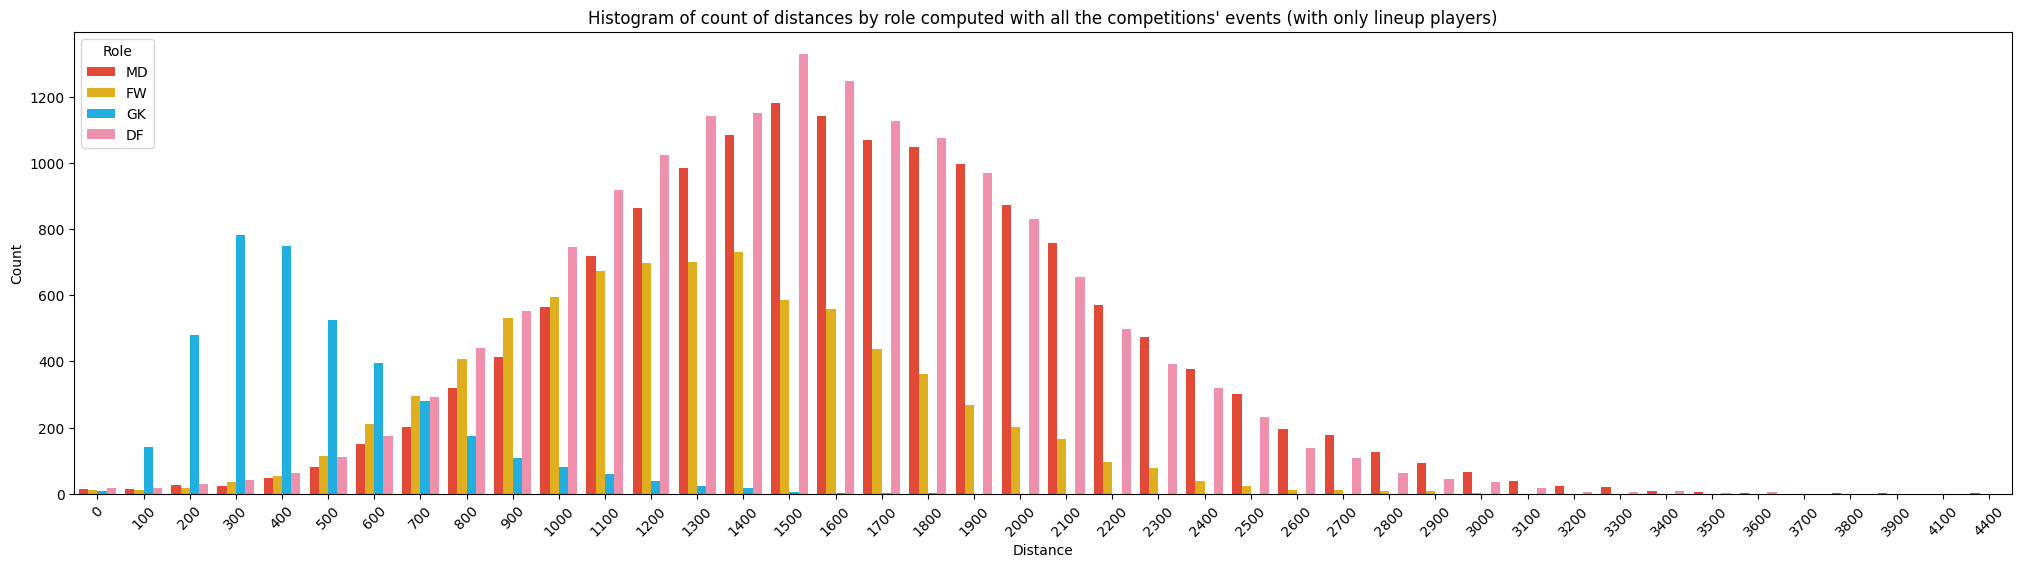

In [37]:
lineup_total_analysis()

Substitution analysis


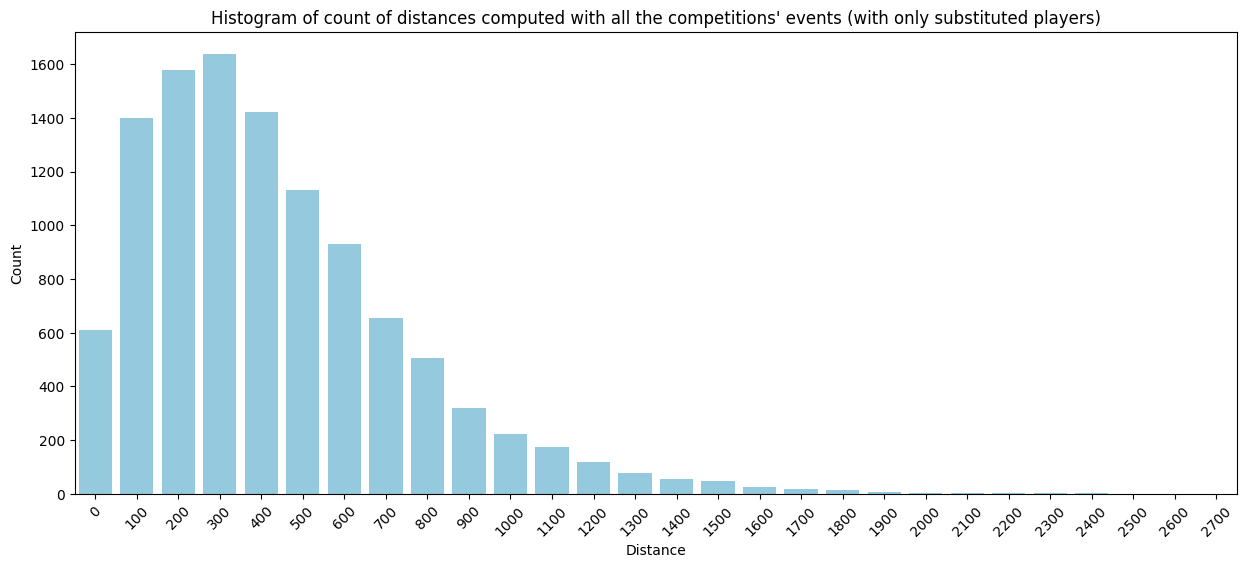

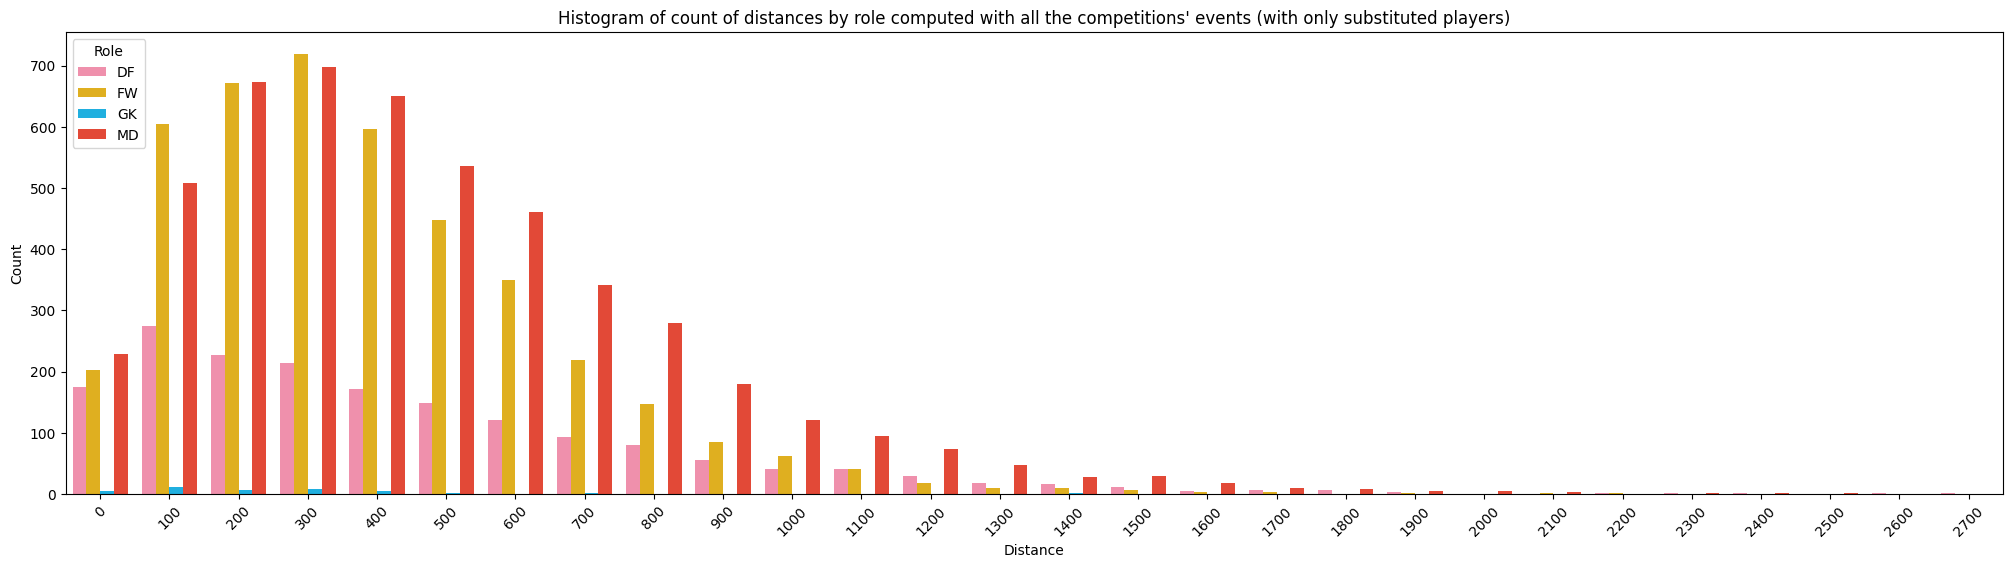

In [38]:
substitution_total_analysis()